# Analyse des Événements Bordelais - MeetingPotes


# Créer un nouvel environnement virtuel
python -m venv venv
source venv/bin/activate

# Installer toutes les dépendances
pip install -r requirements.txt

# Télécharger les modèles spaCy
python -m spacy download fr_core_news_sm
python -m spacy download fr_core_news_md

## Collecte des Événements Bordelais - Septembre 2025

Objectifs :
- Collecter les données événementielles depuis les sources identifiées
- Respecter les bonnes pratiques de web scraping
- Structurer les données de manière cohérente
- Sauvegarder les données brutes pour le traitement ultérieur

In [147]:
# Importations des bibliothèques
import requests
from urllib.parse import urlparse, urljoin
import pandas as pd
import hashlib
from bs4 import BeautifulSoup
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
import os
import re
from datetime import datetime
from selenium.common.exceptions import WebDriverException
import requests
from urllib.parse import urlparse, urljoin
import pandas as pd
import hashlib
from bs4 import BeautifulSoup
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
import os
import re
from datetime import datetime
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import WebDriverException
import logging
from typing import List, Dict, Optional, Any
import unicodedata

In [148]:
# Configuration des paths
OUTPUT_DIR = "bordeaux_events"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Sources de Données Sélectionnées

Nous ciblons des sources officielles et spécialisées :



In [149]:
# Définition des souces 
SOURCES = [

    {
        'name': 'bordeaux-tourisme',
        'url': 'https://www.bordeaux-tourisme.com/agenda.html?date_start=2025-09-01&date_end=2025-09-30',
        'event_list_selector': '.ListSit-item.js-list-sit-item',
        'event_link_selector': '.Card[href]',
        'pagination_type': 'selenium'
    },
     {
        'name': 'bordeaux-metropole',
        'url': 'https://www.bordeaux-metropole.fr/agenda?timings[gte]=2025-08-31T23:00:00.000Z&timings[lte]=2025-09-30T22:59:59.999Z&timings[tz]=Africa/Tunis',
        'event_list_selector': '.oa-list__item',
        'event_link_selector': '.linkContent[href]',
        'pagination_type': 'selenium'
    },
      {
        'name': 'bordeaux-fr',
        'url': 'https://www.bordeaux.fr/evenements?keywords=&field_datetime_range_1=All&field_datetime_range%5Bmin%5D=2025-09-01&field_datetime_range%5Bmax%5D=2025-09-30&items_per_page=50&sort_bef_combine=field_datetime_range_1_ASC',
        'event_list_selector': '.views-row',
        'event_link_selector': '.teasers-events__caption__title[href]',
        'pagination_type': 'beautifulsoup'
    }, {
        'name': 'guide-bordeaux-gironde',
        'url': 'https://www.guide-bordeaux-gironde.com/fr/agenda.html?dates=2025-09-01%3A2025-09-30',
        'event_list_selector': '.event',
        'event_link_selector': '.event-link[href]',
        'pagination_type': 'beautifulsoup'
    }

 
]


### Respect des "robots.txt" et éthique WEB

on veut commencer tout d'abord par vérifier si on respecte des règles d’accès fixées par le site donc on fait acceder pour chaque source au fichier robots.txt est un fichier placé à la racine d’un site web(Il sert à indiquer aux robots d’indexation (Googlebot, scrapers, etc.) quelles pages ou sections du site sont autorisées ou interdites à la consultation automatique)

In [150]:
def fetch_robots_txt(domain_url, timeout=10):

    parsed = urlparse(domain_url)
    base = f"{parsed.scheme}://{parsed.netloc}"
    robots_url = urljoin(base, "/robots.txt")
    res = {"domain": base, "robots_url": robots_url, "raw": None, "parsed": []}
    try:
        r = requests.get(robots_url, timeout=timeout, headers={"User-Agent": "MeetingPotesScraper/1.0"})
        if r.status_code == 200:
            text = r.text
            res["raw"] = text
            # parse basic lines
            ua = None
            for line in text.splitlines():
                line = line.strip()
                if not line or line.startswith("#"): continue
                if ":" not in line: continue
                k, v = line.split(":", 1)
                k = k.strip().lower(); v = v.strip()
                if k == "user-agent":
                    ua = v
                else:
                    res["parsed"].append({"user_agent": ua or "*", "directive": k, "value": v})
        else:
            res["raw"] = None
            res["http_status"] = r.status_code
    except Exception as e:
        res["error"] = str(e)
    return res

# Exemple d'utilisation sur une liste de domains fournies
sources = [
   'https://www.bordeaux-metropole.fr/agenda?timings%5Bgte%5D=2025-08-31T23%3A00%3A00.000Z&timings%5Blte%5D=2025-09-30T22%3A59%3A59.999Z&timings%5Btz%5D=Africa%2FTunis','https://www.bordeaux-tourisme.com/agenda.html?date_start=2025-09-01&date_end=2025-09-30', 'https://www.bordeaux.fr/evenements?keywords=&field_datetime_range_1=All&field_datetime_range%5Bmin%5D=2025-09-01&field_datetime_range%5Bmax%5D=2025-09-30&items_per_page=50&sort_bef_combine=field_datetime_range_1_ASC','https://www.guide-bordeaux-gironde.com/fr/agenda.html?dates=2025-09-01%3A2025-09-30','https://www.eventbrite.fr/d/france--bordeaux/all-events/?page=1&start_date=2025-09-01&end_date=2025-09-30'
]

robots_results = {}
for s in sources:
    res = fetch_robots_txt(s)
    robots_results[s] = res
    time.sleep(0.2)
with open('robots_analysis_summary.txt', 'w', encoding='utf-8') as f:
    for s, res in robots_results.items():
        st = res.get("http_status", "200" if res.get("raw") else "N/A")
        parsed_count = len(res.get("parsed", []))
        err = res.get("error", "None")
        line = f"{s} -> status: {st}, parsed_lines: {parsed_count}, error: {err}\n"
        print(line, end='')  # Afficher dans la console
        f.write(line)  # Écrire dans le fichier


https://www.bordeaux-metropole.fr/agenda?timings%5Bgte%5D=2025-08-31T23%3A00%3A00.000Z&timings%5Blte%5D=2025-09-30T22%3A59%3A59.999Z&timings%5Btz%5D=Africa%2FTunis -> status: 200, parsed_lines: 42, error: None
https://www.bordeaux-tourisme.com/agenda.html?date_start=2025-09-01&date_end=2025-09-30 -> status: 200, parsed_lines: 52, error: None
https://www.bordeaux.fr/evenements?keywords=&field_datetime_range_1=All&field_datetime_range%5Bmin%5D=2025-09-01&field_datetime_range%5Bmax%5D=2025-09-30&items_per_page=50&sort_bef_combine=field_datetime_range_1_ASC -> status: 200, parsed_lines: 31, error: None
https://www.guide-bordeaux-gironde.com/fr/agenda.html?dates=2025-09-01%3A2025-09-30 -> status: 200, parsed_lines: 25, error: None
https://www.eventbrite.fr/d/france--bordeaux/all-events/?page=1&start_date=2025-09-01&end_date=2025-09-30 -> status: 200, parsed_lines: 192, error: None


In [151]:
# ---------- Utilitaires ----------

def save_to_json(data, filename):
    """Sauvegarde des données scrappées des évennements au format JSON"""
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def save_to_csv(data, filename):
    """Sauvegarde des données scrappées des évennements au format CSV"""
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False, encoding='utf-8')

def init_selenium_driver():
    """Initialise et retourne un driver Selenium"""
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
    
    try:
        driver = webdriver.Chrome(options=options)
        return driver
    except WebDriverException:
        logger.error("ChromeDriver non disponible")
        return None
#Gestion de la Navigation
def get_page_content(url, use_selenium=False, driver=None):
    """Récupère le contenu HTML d'une URL"""
    if use_selenium and driver:
        try:
            driver.get(url)
            time.sleep(3)
            return driver.page_source, driver
        except Exception as e:
            logger.error(f"Erreur Selenium avec {url}: {e}")
            return None, None
    else:
        try:
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()
            return response.text, None
        except Exception as e:
            logger.error(f"Erreur Requests avec {url}: {e}")
            return None, None

def extract_text(soup, selector):
    """Extrait le texte d'un sélecteur CSS"""
    element = soup.select_one(selector)
    return element.get_text(strip=True) if element else None

def extract_attr(soup, selector, attr):
    """Extrait un attribut d'un sélecteur CSS"""
    element = soup.select_one(selector)
    return element[attr] if element and element.has_attr(attr) else None
# Gestion des Cookies et Popups
def handle_cookies(driver):
    """Gère les popups de cookies des sitewebs"""
    try:
        cookie_buttons = driver.find_elements(
            By.XPATH, 
            "//button[contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'accepter') or "
            "contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'ok') or "
            "contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'accept')]"
        )
        
        for button in cookie_buttons:
            try:
                button.click()
                time.sleep(1)
                break
            except:
                continue
    except Exception as e:
        logger.error(f"Erreur lors de la gestion des cookies: {e}")

def handle_pagination_bordeaux_fr(html, base_url, css_selector, link_selector, max_pages=20):
    """Gère la pagination spécifique pour Bordeaux.fr"""
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} événements trouvés sur la page {page_count}")
        
        # Trouver le lien vers la page suivante (Bordeaux.fr utilise souvent une pagination Drupal)
        soup = BeautifulSoup(current_html, 'html.parser')
        next_link = soup.select_one('.pager__item--next a, a[rel="next"], li.pager-next a, .pager-next a')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # Récupérer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(2)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))

# EXTRACTION DES URLs D'ÉVÉNEMENTS
def extract_event_urls_from_page(html, base_url, css_selector, link_selector):
    """Extrait les URLs d'événements d'une page HTML"""
    soup = BeautifulSoup(html, 'html.parser')
    event_elements = soup.select(css_selector)
    
    event_urls = []
    for element in event_elements:
        link = element.select_one(link_selector)
        if link and link.get('href'):
            event_url = urljoin(base_url, link['href'])
            # Filtrer les URLs non valides
            if event_url.startswith(('http://', 'https://')):
                event_urls.append(event_url)
    
    return event_urls
def handle_pagination_selenium(driver, base_url, css_selector, link_selector, max_pages=10):
    """Gère la pagination avec Selenium"""
    all_event_urls = []
    page_count = 1
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        current_html = driver.page_source
        event_urls = extract_event_urls_from_page(current_html, base_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} événements trouvés sur la page {page_count}")
        
        # Essayer de trouver et cliquer sur le bouton suivant
        try:
            next_buttons = driver.find_elements(
                By.XPATH, 
                "//a[contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'suivant') or "
                "contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'next') or "
                "contains(@class, 'next') or contains(@rel, 'next')]"
            )
            
            if next_buttons:
                next_buttons[0].click()
                time.sleep(3)
                page_count += 1
            else:
                print("Plus de pages à traiter.")
                break
                
        except Exception as e:
            print(f"Erreur lors de la navigation: {e}")
            break
    
    return list(set(all_event_urls))  # Supprimer les doublons
def handle_pagination_bordeaux_fr(html, base_url, css_selector, link_selector, max_pages=20):
    """Gère la pagination spécifique pour Bordeaux.fr"""
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} événements trouvés sur la page {page_count}")
        
        # Trouver le lien vers la page suivante (Bordeaux.fr utilise souvent une pagination Drupal)
        soup = BeautifulSoup(current_html, 'html.parser')
        next_link = soup.select_one('.pager__item--next a, a[rel="next"], li.pager-next a, .pager-next a')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # Récupérer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(2)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))

def handle_pagination_guide_bordeaux_gironde(html, base_url, css_selector, link_selector, max_pages=111):
    """Gère la pagination spécifique pour Guide Bordeaux Gironde"""
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} événements trouvés sur la page {page_count}")
        
        # Trouver le lien vers la page suivante
        soup = BeautifulSoup(current_html, 'html.parser')
        next_link = None
        
        # Chercher le lien de la page suivante dans la pagination
        pagination_links = soup.select('.navigBarre a.num, .navigBarre a.next')
        for link in pagination_links:
            link_text = link.get_text(strip=True)
            if link_text.isdigit() and int(link_text) == page_count + 1:
                next_link = link
                break
        
        if not next_link:
            # Chercher le bouton "suivant"
            next_link = soup.select_one('.navigBarre a.next')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # Récupérer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(2)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))

def handle_pagination_beautifulsoup(html, base_url, css_selector, link_selector, max_pages=10):
    """Gère la pagination avec BeautifulSoup"""
    # Détecter le type de site
    soup = BeautifulSoup(html, 'html.parser')
    
    # Bordeaux.fr (Drupal)
    if soup.select_one('.view--display-events') or 'bordeaux.fr' in base_url:
        return handle_pagination_bordeaux_fr(html, base_url, css_selector, link_selector, max_pages)
    if soup.select_one('.eventList') or 'guide-bordeaux-gironde.com' in base_url:
        return handle_pagination_guide_bordeaux_gironde(html, base_url, css_selector, link_selector, max_pages)
    
    # Pagination standard pour les autres sites
    all_event_urls = []
    page_count = 1
    
    current_html = html
    current_url = base_url
    
    while page_count <= max_pages:
        print(f"Traitement de la page {page_count}...")
        
        # Extraire les URLs de la page actuelle
        event_urls = extract_event_urls_from_page(current_html, current_url, css_selector, link_selector)
        all_event_urls.extend(event_urls)
        
        print(f"{len(event_urls)} événements trouvés sur la page {page_count}")
        
        # Trouver le lien vers la page suivante
        next_link = soup.select_one('a.next, a[rel="next"], .pagination-next, .next-page')
        
        if next_link and next_link.get('href'):
            next_url = urljoin(current_url, next_link['href'])
            
            # Récupérer la page suivante
            next_html, _ = get_page_content(next_url, use_selenium=False)
            if next_html:
                current_html = next_html
                current_url = next_url
                page_count += 1
                time.sleep(1)
            else:
                break
        else:
            break
    
    return list(set(all_event_urls))


### EXTRACTION DES DÉTAILS DES ÉVÉNEMENTS:Approche Spécifique par Source


In [152]:


def extract_event_details_bourdeaux_tourisme(html, event_url, source_name):
    """Extrait les détails complets d'un événement depuis la page HTML"""
    soup = BeautifulSoup(html, 'html.parser')
    
    # Générer un ID unique pour l'événement
    event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]
    
    # Extraire chaque information
    event_data = {
        'event_id': f"{source_name}_{event_id}",
        'title': extract_text(soup, 'h1, .event-title, .title, .SitIntro-title') or "",
        'description': extract_description_bourdeaux_tourisme(soup) or "",
        'date': extract_date_info_bourdeaux_tourisme(soup) or "",
        'time': extract_time_info_bourdeaux_tourisme(soup) or "",
        'location': extract_text(soup, '.event-location, .location, .place, address strong') or "",
        'address': extract_address_bourdeaux_tourisme(soup) or "",
        'category': extract_categories_bourdeaux_tourisme(soup),
        'tags': extract_tags_bourdeaux_tourisme(soup),
        'price': extract_price_bourdeaux_tourisme(soup) or "",
        'ticket_url': extract_ticket_url_bourdeaux_tourisme(soup) or "",
        'organizer': extract_organizer_bourdeaux_tourisme(soup) or "",
        'image_url': extract_image_url_bourdeaux_tourisme(soup) or "",
        'source': source_name,
        'source_url': event_url,
        'scraped_at': datetime.now().isoformat()
    }
    
    return {k: v for k, v in event_data.items() if v is not None and v != "" and v != []}

def extract_description_bourdeaux_tourisme(soup):
    """Extrait la description de l'événement"""
    selectors = [
        '.event-description, .description, .content, .SitIntro-container p',
        'meta[property="og:description"]',
        'meta[name="description"]'
    ]
    
    for selector in selectors:
        if selector.startswith('meta'):
            meta = soup.find('meta', {'property': selector.split('[')[1].split(']')[0]}) or soup.find('meta', {'name': selector.split('[')[1].split(']')[0]})
            if meta and meta.get('content'):
                return meta['content']
        else:
            element = soup.select_one(selector)
            if element:
                return element.get_text(strip=True)
    
    return ""

def extract_date_info_bourdeaux_tourisme(soup):
    """Extrait les informations de date"""
    date_text = extract_text(soup, '.event-date, .date, .Card-label, .SitIntro-date')
    return date_text or ""

def extract_time_info_bourdeaux_tourisme(soup):
    """Extrait les informations horaires"""
    time_text = extract_text(soup, '.event-time, .time, .SitCalendar-day span:nth-child(2)')
    return time_text or ""

def extract_address_bourdeaux_tourisme(soup):
    """Extrait l'adresse complète"""
    address_element = soup.select_one('address, .event-address, .address')
    if address_element:
        return address_element.get_text(separator=' ', strip=True)
    return ""

def extract_categories_bourdeaux_tourisme(soup):
    """Extrait les catégories de l'événement"""
    meta_element = soup.select_one('.SitIntro-meta, .event-category, .category')
    if meta_element:
        return [tag.strip() for tag in meta_element.get_text().split(',')]
    return []

def extract_tags_bourdeaux_tourisme(soup):
    """Extrait les mots-clés/tags"""
    tags = []
    
    # Méta keywords
    meta_keywords = soup.find('meta', {'name': 'keywords'})
    if meta_keywords and meta_keywords.get('content'):
        tags.extend([tag.strip() for tag in meta_keywords['content'].split(',')])
    
    return tags

def extract_price_bourdeaux_tourisme(soup):
    """Extrait les informations de prix"""
    price_element = soup.select_one('.event-price, .price, .tarif')
    if price_element:
        return price_element.get_text(strip=True)
    
    # Chercher dans tout le texte
    text = soup.get_text()
    price_pattern = r'\d+\s*€'
    prices = re.findall(price_pattern, text)
    return prices[0] if prices else ""

def extract_ticket_url_bourdeaux_tourisme(soup):
    """Extrait l'URL de réservation"""
    reservation_btn = soup.select_one('.SitMap-button a[href]')
    if reservation_btn:
        href = reservation_btn.get('href')
        if href and not href.startswith(('javascript:', '#')):
            return href
    
    reservation_links = soup.select('a[href*="reserv"], a[href*="book"], a[href*="billet"], a[href*="eventbrite"], a[href*="weezevent"]')
    for link in reservation_links:
        href = link.get('href')
        if href and not href.startswith(('javascript:', '#')):
            return href
    
    return ""

def extract_organizer_bourdeaux_tourisme(soup):
    """Extrait le nom de l'organisateur"""
    organizer_element = soup.select_one('.event-organizer, .organizer')
    if organizer_element:
        return organizer_element.get_text(strip=True)
    
    return ""

def extract_image_url_bourdeaux_tourisme(soup):
    """Extrait l'URL de l'image principale"""
    image_element = soup.select_one('.event-image img, .main-image img, .Slider-slide img')
    if image_element and image_element.get('src'):
        return image_element['src']
    
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return ""




In [153]:
def extract_event_details_bordeaux_metropole(html, event_url, source_name):
    """Extrait les détails complets d'un événement depuis la page HTML"""
    soup = BeautifulSoup(html, 'html.parser')
    
    # Générer un ID unique pour l'événement
    event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]
    
    # Extraire chaque information
    event_data = {
        'event_id': f"{source_name}_{event_id}",
        'title': extract_text(soup, '.OpenAgenda-Full-title h1') or "",
        'description': extract_description_bordeaux_metropole(soup) or "",
        'date': extract_date_info_bordeaux_metropole(soup) or "",
        'time': extract_time_info_bordeaux_metropole(soup) or "",
        'location': extract_text(soup, '.OpenAgenda-Full-city') or "",
        'address': extract_address_bordeaux_metropole(soup) or "",
        'category': extract_categories_bordeaux_metropole(soup),
        'tags': extract_tags_bordeaux_metropole(soup),
        'price': extract_price_bordeaux_metropole(soup) or "free",
        'ticket_url': extract_ticket_url_bordeaux_metropole(soup) or "",
        'organizer': extract_organizer_bordeaux_metropole(soup) or "",
        'image_url': extract_image_url_bordeaux_metropole(soup) or "",
        'source': source_name,
        'source_url': event_url,
        'scraped_at': datetime.now().isoformat()
    }
    
    return {k: v for k, v in event_data.items() if v is not None and v != "" and v != []}

def extract_description_bordeaux_metropole(soup):
    """Extrait la description de l'événement"""
    # Section principale
    desc = soup.select_one('.OpenAgenda-description')
    if desc:
        return desc.get_text(" ", strip=True)
    
    # Meta description (fallback)
    meta = soup.find('meta', {'name': 'description'}) or soup.find('meta', {'property': 'og:description'})
    if meta and meta.get('content'):
        return meta['content']
    
    return ""

def extract_date_info_bordeaux_metropole(soup):
    """Extrait les informations de date"""
    date_element = soup.select_one('.OpenAgenda-Full-date')
    if date_element:
        return date_element.get_text(strip=True)
    return ""

def extract_time_info_bordeaux_metropole(soup):
    """Extrait les informations horaires"""
    time_element = soup.select_one('.OpenAgenda-Full-schedule')
    if time_element:
        return time_element.get_text(" ", strip=True).replace("Horaires", "").strip()
    return ""

def extract_address_bordeaux_metropole(soup):
    """Extrait l'adresse complète"""
    address_element = soup.select_one('.OpenAgenda-Full-address')
    if address_element:
        return address_element.get_text(" ", strip=True).replace("Adresse", "").strip()
    return ""

def extract_categories_bordeaux_metropole(soup):
    """Extrait les catégories de l'événement"""
    return []

def extract_tags_bordeaux_metropole(soup):
    """Extrait les mots-clés/tags depuis meta keywords"""
    tags = []
    meta_keywords = soup.find('meta', {'name': 'keywords'})
    if meta_keywords and meta_keywords.get('content'):
        tags.extend([tag.strip() for tag in meta_keywords['content'].split(',')])
    return tags

def extract_price_bordeaux_metropole(soup):
    """Extrait les informations de prix"""
    price_element = soup.select_one('.OpenAgenda-Full-conditions')
    if price_element:
        return price_element.get_text(" ", strip=True).replace("Tarif", "").strip()
    return ""

def extract_ticket_url_bordeaux_metropole(soup):
    """Extrait l'URL d'inscription"""
    ticket_element = soup.select_one('.OpenAgenda-Full-Registration a[href]')
    if ticket_element:
        return ticket_element.get('href')
    return ""

def extract_organizer_bordeaux_metropole(soup):
    """Extrait l'organisateur de l'événement"""
    return ""

def extract_image_url_bordeaux_metropole(soup):
    """Extrait l'URL de l'image principale"""
    image_element = soup.select_one('.OpenAgenda-Full-main img')
    if image_element and image_element.get('src'):
        return image_element['src']
    
    # Fallback og:image
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return ""

In [154]:
import re
from bs4 import BeautifulSoup
import hashlib
from datetime import datetime

def extract_bordeaux_fr_title(soup):
    """Extrait le titre de l'événement pour Bordeaux.fr"""
    title_element = soup.select_one('.node-event-single__header__title, h1.title-h1')
    if title_element:
        return title_element.get_text(strip=True)
    
    meta_title = soup.find('meta', property='og:title')
    if meta_title and meta_title.get('content'):
        return meta_title['content']
    
    return None

def extract_bordeaux_fr_description(soup):
    """Extrait la description de l'événement - seulement les paragraphes"""
    description_parts = []
    
    # Extraire uniquement les paragraphes de la description principale
    desc_elements = soup.select('.node-event-single__body__desc.rich-text p')
    for p in desc_elements:
        text = p.get_text(strip=True)
        # Éviter les textes de réservation
        if not any(keyword in text.lower() for keyword in ['réservez', 'reservation', 'billetterie']):
            description_parts.append(text)
    
    return ' '.join(description_parts) if description_parts else None

def extract_bordeaux_fr_date_range(soup):
    """Extrait la plage de dates depuis les spans start-date et end-date"""
    start_date = soup.select_one('span.start-date')
    end_date = soup.select_one('span.end-date')
    
    if start_date and end_date:
        return f"{start_date.get_text(strip=True)} {end_date.get_text(strip=True)}"
    
    # Fallback: calculer à partir des dates détaillées
    dates = extract_bordeaux_fr_detailed_dates_scheduler(soup)
    if dates:
        first_date = dates[0]['date']
        last_date = dates[-1]['date']
        return f"Du {first_date} au {last_date}"
    
    return None

def extract_bordeaux_fr_detailed_dates_scheduler(soup):
    """Extrait les dates détaillées avec le format structuré demandé"""
    dates_list = []
    dates_element = soup.select_one('#collapse-event-dates .accordion__container')
    
    if dates_element:
        for li in dates_element.find_all('li'):
            date_text = li.get_text(strip=True)
            
            # Pattern pour extraire les informations
            pattern = r'(\w+)\s+(\d{1,2}\s+\w+\s+\d{4})\s+de\s+(\d{1,2}h\d{0,2})\s+à\s+(\d{1,2}h\d{0,2})'
            match = re.match(pattern, date_text)
            
            if match:
                weekday = match.group(1)  # Vendredi, Samedi, etc.
                date_str = match.group(2)  # 4 avril 2025
                start_time = match.group(3)  # 14h00
                end_time = match.group(4)    # 20h00
                
                dates_list.append({
                    "date": date_str,
                    "weekday": weekday,
                    "start_time": start_time,
                    "end_time": end_time
                })
    
    return dates_list if dates_list else None

def extract_bordeaux_fr_time_summary(soup):
    """Extrait un résumé des horaires types"""
    dates = extract_bordeaux_fr_detailed_dates_scheduler(soup)
    if not dates:
        return None
    
    # Regrouper par plages horaires similaires
    time_slots = {}
    for date in dates:
        time_key = f"{date['start_time']}-{date['end_time']}"
        if time_key not in time_slots:
            time_slots[time_key] = 0
        time_slots[time_key] += 1
    
    # Retourner les plages horaires les plus fréquentes
    if time_slots:
        return ', '.join([f"{key.split('-')[0]} à {key.split('-')[1]}" 
                         for key in sorted(time_slots.keys(), 
                                         key=lambda x: time_slots[x], reverse=True)[:3]])
    
    return None

def extract_bordeaux_fr_location(soup):
    """Extrait le lieu de l'événement"""
    location_element = soup.select_one('.paragraph-container__border__wrapper__element .title')
    if location_element:
        return location_element.get_text(strip=True)
    return None

def extract_bordeaux_fr_address(soup):
    """Extrait l'adresse complète"""
    address_elements = soup.select('.paragraph-container__border__wrapper__element .address')
    if address_elements:
        return ', '.join([addr.get_text(strip=True) for addr in address_elements])
    return None

def extract_bordeaux_fr_categories(soup):
    """Extrait les catégories"""
    categories = []
    tag_elements = soup.select('.node-event-single__header__tags .node-tags__item a')
    for tag in tag_elements:
        categories.append(tag.get_text(strip=True))
    return categories if categories else None

def extract_bordeaux_fr_tags(soup):
    """Extrait les mots-clés/tags"""
    tags = extract_bordeaux_fr_categories(soup) or []
    content = soup.get_text()
    potential_tags = ['réalité virtuelle', 'patrimoine', 'culture', 'visite', 'exposition', 
                     'immersif', 'médiéval', 'histoire']
    for tag in potential_tags:
        if tag.lower() in content.lower():
            tags.append(tag)
    return list(set(tags)) if tags else None

def extract_bordeaux_fr_price(soup):
    """Extrait le prix"""
    price_section = soup.select_one('#collapse-conditions .accordion__container')
    if price_section:
        price_text = price_section.get_text(strip=True)
        if '€' in price_text:
            return price_text
    return None

def extract_bordeaux_fr_ticket_url(soup):
    """Extrait l'URL de réservation"""
    reservation_section = soup.select_one('#collapse-registration-tool a[href]')
    if reservation_section:
        return reservation_section.get('href')
    return None

def extract_bordeaux_fr_organizer(soup):
    """Extrait l'organisateur"""
    location = extract_bordeaux_fr_location(soup)
    if location and "Eclipso" in location:
        return location
    return "Ville de Bordeaux"

def extract_bordeaux_fr_image(soup):
    """Extrait l'URL de l'image principale"""
    main_image = soup.select_one('.node-event-single__body__main-image img')
    if main_image and main_image.get('src'):
        return main_image['src']
    
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return None

def extract_bordeaux_fr_public(soup):
    """Extrait les informations sur le public cible"""
    public_element = soup.select_one('#collapse-public .accordion__container')
    if public_element:
        return public_element.get_text(strip=True)
    return None

def extract_event_details_bourdeaux_fr(html, event_url):
    """Extrait les détails spécifiques pour Bordeaux.fr - version améliorée"""
    soup = BeautifulSoup(html, 'html.parser')
    
    event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]
    
    # Extraire les dates détaillées structurées
    detailed_dates = extract_bordeaux_fr_detailed_dates_scheduler(soup)
    
    event_data = {
        'event_id': f"bordeaux-fr_{event_id}",
        'title': extract_bordeaux_fr_title(soup),
        'description': extract_bordeaux_fr_description(soup),
        'date': extract_bordeaux_fr_date_range(soup),  # Plage de dates formatée
        'time': extract_bordeaux_fr_time_summary(soup),  # Résumé des horaires
        'location': extract_bordeaux_fr_location(soup),
        'address': extract_bordeaux_fr_address(soup),
        'category': extract_bordeaux_fr_categories(soup),
        'tags': extract_bordeaux_fr_tags(soup),
        'price': extract_bordeaux_fr_price(soup),
        'ticket_url': extract_bordeaux_fr_ticket_url(soup),
        'organizer': extract_bordeaux_fr_organizer(soup),
        'image_url': extract_bordeaux_fr_image(soup),
        'public_info': extract_bordeaux_fr_public(soup),
        'schedule': detailed_dates,  # Dates détaillées structurées
        'source': 'bordeaux-fr',
        'source_url': event_url,
        'scraped_at': datetime.now().isoformat()
    }
    
    # Nettoyer les données (supprimer les valeurs None)
    return {k: v for k, v in event_data.items() if v is not None}

In [155]:
def extract_guide_bordeaux_gironde_title(soup):
    """Extrait le titre de l'événement pour Guide Bordeaux Gironde"""
    title_element = soup.select_one('.titlePage h1, h1')
    if title_element:
        return title_element.get_text(strip=True)
    
    # Fallback pour les meta données
    meta_title = soup.find('meta', property='og:title')
    if meta_title and meta_title.get('content'):
        return meta_title['content']
    
    return None

def extract_guide_bordeaux_gironde_description(soup):
    """Extrait la description complète de l'événement pour Guide Bordeaux Gironde"""
    description_parts = []

    # Sélectionne le bloc principal de description
    desc_container = soup.select_one('.richContent.event-details')
    if desc_container:
        # On prend seulement les <p> sans contact, maj ou crédits
        for p in desc_container.find_all('p'):
            if not p.get('class') or not any(c in ['event-contact', 'event-maj', 'event-credit'] for c in p.get('class')):
                description_parts.append(p.get_text(" ", strip=True))

    # Fallback sur anciens sélecteurs si jamais le format change
    if not description_parts:
        desc_element = soup.select_one('.event-description, .content-text, .rich-text')
        if desc_element:
            description_parts.append(desc_element.get_text(" ", strip=True))

    return ' '.join(description_parts) if description_parts else None


def extract_guide_bordeaux_gironde_date(soup):
    """Extrait les dates de l'événement pour Guide Bordeaux Gironde"""
    # Date dans l'en-tête
    date_element = soup.select_one('.event-header-periode .lib')
    if date_element:
        return date_element.get_text(strip=True)
    
    # Chercher dans le contenu
    content = soup.get_text()
    date_pattern = r'\d{1,2}\s+\w+\s+\d{4}'
    dates = re.findall(date_pattern, content)
    if dates:
        return dates[0]
    
    return None

def extract_guide_bordeaux_gironde_time(soup):
    """Extrait les horaires de l'événement pour Guide Bordeaux Gironde"""
    # Chercher les horaires dans le contenu
    content = soup.get_text()
    time_pattern = r'\d{1,2}h\d{0,2}'
    times = re.findall(time_pattern, content)
    if times:
        return ', '.join(times)
    
    return None

def extract_guide_bordeaux_gironde_location(soup):
    """Extrait le lieu de l'événement pour Guide Bordeaux Gironde"""
    # Lieu dans l'en-tête
    location_element = soup.select_one('.event-header-location .lib')
    if location_element:
        return location_element.get_text(strip=True)
    
    # Chercher dans le contenu
    content = soup.get_text()
    location_keywords = ['à', 'au', 'dans', 'sur']
    for keyword in location_keywords:
        pattern = fr"{keyword}\s+([A-Za-zÀ-ÿ\-'\s]+)(?=\.|,|$)"
        matches = re.findall(pattern, content, re.IGNORECASE)
        if matches:
            return matches[0].strip()
    
    return None

def extract_guide_bordeaux_gironde_address(soup):
    """Extrait l'adresse complète pour Guide Bordeaux Gironde"""
    # Chercher l'adresse dans le contenu
    content = soup.get_text()
    address_pattern = r'\d+\s+[A-Za-zÀ-ÿ\s]+,?\s*\d{5}\s+[A-Za-zÀ-ÿ\s]+'
    addresses = re.findall(address_pattern, content)
    if addresses:
        return addresses[0]
    
    return None

def extract_guide_bordeaux_gironde_categories(soup):
    """Extrait les catégories pour Guide Bordeaux Gironde"""
    categories = []
    
    # Catégories dans le fil d'Ariane
    ariane_elements = soup.select('.ariane a.item-bt')
    for element in ariane_elements:
        text = element.get_text(strip=True)
        if text and text not in ['Accueil', 'Agenda']:
            categories.append(text)
    
    return categories if categories else None

def extract_guide_bordeaux_gironde_tags(soup):
    """Extrait les mots-clés/tags pour Guide Bordeaux Gironde"""
    tags = extract_guide_bordeaux_gironde_categories(soup)
    
    # Ajouter des tags basés sur le contenu
    content = soup.get_text()
    potential_tags = ['patrimoine', 'culture', 'visite', 'exposition', 'concert', 'festival', 
                     'spectacle', 'sport', 'animation', 'dégustation', 'marché', 'vin']
    
    for tag in potential_tags:
        if tag.lower() in content.lower():
            if tags is None:
                tags = []
            tags.append(tag)
    
    return list(set(tags)) if tags else None

def extract_guide_bordeaux_gironde_price(soup):
    """Extrait le prix de l'événement pour Guide Bordeaux Gironde"""
    # Chercher dans tout le contenu
    content = soup.get_text()
    price_patterns = [
        r'gratuit', r'payant', r'entrée\s*:\s*\d+\s*€', r'\d+\s*€', 
        r'tarif\s*:\s*\d+', r'prix\s*:\s*\d+', r'(\d+)\s*euros?'
    ]
    
    for pattern in price_patterns:
        matches = re.findall(pattern, content, re.IGNORECASE)
        if matches:
            return matches[0] if isinstance(matches[0], str) else f"{matches[0]} €"
    
    return None

def extract_guide_bordeaux_gironde_ticket_url(soup):
    """Extrait l'URL de réservation pour Guide Bordeaux Gironde"""
    # Chercher des liens de réservation
    reservation_links = soup.select('a[href*="reservation"], a[href*="billetterie"], a[href*="booking"]')
    for link in reservation_links:
        href = link.get('href')
        if href:
            return href
    
    # Chercher dans le contenu
    content = soup.get_text()
    url_pattern = r'https?://[^\s]+'
    urls = re.findall(url_pattern, content)
    for url in urls:
        if any(keyword in url.lower() for keyword in ['reservation', 'billetterie', 'booking']):
            return url
    
    return None

def extract_guide_bordeaux_gironde_organizer(soup):
    """Extrait l'organisateur pour Guide Bordeaux Gironde"""
    # Par défaut
    organizer = "Guide Bordeaux Gironde"
    
    # Chercher dans le contenu
    content = soup.get_text()
    organizer_patterns = [
        r'organisé par\s+([^\.]+)',
        r'par\s+([^\.]+)',
        r'contact\s*:\s*([^\.]+)'
    ]
    
    for pattern in organizer_patterns:
        matches = re.findall(pattern, content, re.IGNORECASE)
        if matches:
            return matches[0].strip()
    
    return organizer

def extract_guide_bordeaux_gironde_image(soup):
    """Extrait l'URL de l'image principale pour Guide Bordeaux Gironde"""
    # Image principale
    main_image = soup.select_one('.event-header-img-main img, .event-header-img img')
    if main_image and main_image.get('src'):
        # Convertir l'URL relative en absolue
        src = main_image['src']
        if src.startswith('/'):
            return f"https://www.guide-bordeaux-gironde.com{src}"
        return src
    
    # Image meta
    meta_image = soup.find('meta', property='og:image')
    if meta_image and meta_image.get('content'):
        return meta_image['content']
    
    return None

def extract_guide_bordeaux_gironde_geo(soup):
    """Extrait les coordonnées géographiques pour Guide Bordeaux Gironde"""
    # Chercher des données geo dans les scripts
    scripts = soup.find_all('script')
    for script in scripts:
        if script.string:
            # Chercher des coordonnées latitude/longitude
            lat_pattern = r'latitude["\']\s*:\s*([-\d.]+)'
            lng_pattern = r'longitude["\']\s*:\s*([-\d.]+)'
            
            lat_match = re.search(lat_pattern, script.string)
            lng_match = re.search(lng_pattern, script.string)
            
            if lat_match and lng_match:
                try:
                    return {
                        'latitude': float(lat_match.group(1)),
                        'longitude': float(lng_match.group(1))
                    }
                except ValueError:
                    continue
    
    return None

def extract_event_guide_bordeaux_gironde(html, event_url, source_name):
    """Extrait les détails complets d'un événement selon la source"""
    try:
        soup = BeautifulSoup(html, 'html.parser')
        event_id = hashlib.sha256(event_url.encode()).hexdigest()[:16]

        # --- Cas spécifique : Guide Bordeaux Gironde ---
        if source_name == 'guide-bordeaux-gironde':
            event_data = {
                'event_id': f"{source_name}_{event_id}",
                'title': extract_guide_bordeaux_gironde_title(soup),
                'description': extract_guide_bordeaux_gironde_description(soup),
                'date': extract_guide_bordeaux_gironde_date(soup),
                'time': extract_guide_bordeaux_gironde_time(soup),
                'location': extract_guide_bordeaux_gironde_location(soup),
                'address': extract_guide_bordeaux_gironde_address(soup),
                'category': extract_guide_bordeaux_gironde_categories(soup),
                'tags': extract_guide_bordeaux_gironde_tags(soup),
                'price': extract_guide_bordeaux_gironde_price(soup),
                'ticket_url': extract_guide_bordeaux_gironde_ticket_url(soup),
                'organizer': extract_guide_bordeaux_gironde_organizer(soup),
                'image_url': extract_guide_bordeaux_gironde_image(soup),
                'source': source_name,
                'source_url': event_url,
                'scraped_at': datetime.now().isoformat()
            }

            # Ajouter coordonnées GPS si disponibles
            geo_data = extract_guide_bordeaux_gironde_geo(soup)
            if geo_data:
                event_data.update(geo_data)

        # --- Fallback générique ---
        else:
            event_data = {
                'event_id': f"{source_name}_{event_id}",
                'title': extract_text(soup, 'h1'),
                'description': extract_text(soup, 'meta[property="og:description"]')
                                or extract_text(soup, 'meta[name="description"]'),
                'source': source_name,
                'source_url': event_url,
                'scraped_at': datetime.now().isoformat()
            }

        # Supprimer les clés avec valeur None
        return {k: v for k, v in event_data.items() if v is not None}

    except Exception as e:
        print(f"⚠️ Erreur lors de l'extraction des détails ({source_name}): {event_url} - {e}")
        # Retourner au moins les infos minimales
        return {
            'event_id': f"{source_name}_{hashlib.sha256(event_url.encode()).hexdigest()[:16]}",
            'source_url': event_url,
            'source': source_name,
            'scraped_at': datetime.now().isoformat(),
            'error': str(e)
        }


In [156]:
# ========== FONCTIONS PRINCIPALES PAR SOURCE ==========

def scrape_bordeaux_fr(source):
    """Scrape la source Bordeaux Tourisme (une seule source)"""
    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")

    event_urls = []
    driver = None

    try:
        # Gestion pagination selon le type
        if source['pagination_type'] == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver, source['url'],
                        source['event_list_selector'], source['event_link_selector']
                    )
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html, source['url'],
                    source['event_list_selector'], source['event_link_selector']
                )

    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()

    print(f"Total URLs trouvées pour {source['name']}: {len(event_urls)}")

    # Scraper les détails des événements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping événement {i+1}/{len(event_urls)}: {event_url}")
        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_details_bourdeaux_fr(html, event_url)
                if event_data:
                    events_data.append(event_data)

            # Pause pour éviter de spammer le serveur
            time.sleep(1)

        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue

    # Sauvegarde
    if events_data:
        # JSON
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        # CSV
        df = pd.DataFrame(events_data)
        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        df.to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonnées sauvegardées :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} événements")

    return events_data



In [157]:
# ========== FONCTIONS PRINCIPALES PAR SOURCE ==========

def scrape_bordeaux_tourisme(source):
    """Scrape la source Bordeaux Tourisme (une seule source)"""
    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")

    event_urls = []
    driver = None

    try:
        # Gestion pagination selon le type
        if source['pagination_type'] == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver, source['url'],
                        source['event_list_selector'], source['event_link_selector']
                    )
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html, source['url'],
                    source['event_list_selector'], source['event_link_selector']
                )

    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()

    print(f"Total URLs trouvées pour {source['name']}: {len(event_urls)}")

    # Scraper les détails des événements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping événement {i+1}/{len(event_urls)}: {event_url}")
        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_details_bourdeaux_tourisme(html, event_url, source['name'])
                if event_data:
                    events_data.append(event_data)

            # Pause pour éviter de spammer le serveur
            time.sleep(1)

        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue

    # Sauvegarde
    if events_data:
        # JSON
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        # CSV
        df = pd.DataFrame(events_data)
        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        df.to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonnées sauvegardées :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} événements")

    return events_data



In [158]:
def scrape_bordeaux_metropole(source):
    """Scrape la source Bordeaux Métropole (une seule source)"""
    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")
    
    event_urls = []
    driver = None
    
    try:
        # Gestion de la pagination
        if source['pagination_type'] == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver, source['url'], 
                        source['event_list_selector'], source['event_link_selector']
                    )
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html, source['url'], 
                    source['event_list_selector'], source['event_link_selector']
                )
                
    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()
    
    print(f"Total URLs trouvées pour {source['name']}: {len(event_urls)}")
    
    # Scraper les détails des événements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping événement {i+1}/{len(event_urls)}: {event_url}")
        
        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_details_bordeaux_metropole(html, event_url, source['name'])
                if event_data:
                    events_data.append(event_data)
            
            # Pause respectueuse
            time.sleep(1)
            
        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue
    
    # Sauvegarde JSON + CSV
    if events_data:
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        pd.DataFrame(events_data).to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonnées sauvegardées :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} événements")
    
    return events_data


In [159]:
def scrape_guide_bordeaux_gironde(source):

    print(f"\n=== SCRAPING DE {source['name'].upper()} ===")

    event_urls = []
    driver = None

    try:
        # Pagination avec Selenium
        if source.get('pagination_type') == 'selenium':
            driver = init_selenium_driver()
            if driver:
                html, driver = get_page_content(source['url'], use_selenium=True, driver=driver)
                if html:
                    handle_cookies(driver)
                    event_urls = handle_pagination_selenium(
                        driver,
                        source['url'],
                        source['event_list_selector'],
                        source['event_link_selector']
                    )
        # Pagination classique avec requests + BeautifulSoup
        else:
            html, _ = get_page_content(source['url'], use_selenium=False)
            if html:
                event_urls = handle_pagination_beautifulsoup(
                    html,
                    source['url'],
                    source['event_list_selector'],
                    source['event_link_selector']
                )

    except Exception as e:
        print(f"Erreur lors du scraping de {source['name']}: {e}")
    finally:
        if driver:
            driver.quit()

    print(f"Total URLs trouvées pour {source['name']}: {len(event_urls)}")

    # Scraper les détails des événements
    events_data = []
    for i, event_url in enumerate(event_urls):
        print(f"Scraping événement {i+1}/{len(event_urls)}: {event_url}")

        try:
            html, _ = get_page_content(event_url, use_selenium=False)
            if html:
                event_data = extract_event_guide_bordeaux_gironde(html, event_url, source['name'])
                if event_data:
                    events_data.append(event_data)

            time.sleep(1)  # pause anti-bot

        except Exception as e:
            print(f"Erreur lors du scraping de {event_url}: {e}")
            continue

    # Sauvegarde JSON + CSV
    if events_data:
        json_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(events_data, f, ensure_ascii=False, indent=2)

        csv_file = os.path.join(OUTPUT_DIR, f"{source['name']}_events.csv")
        pd.DataFrame(events_data).to_csv(csv_file, index=False, encoding='utf-8')

        print(f"\nDonnées sauvegardées :")
        print(f"- JSON: {json_file}")
        print(f"- CSV: {csv_file}")
        print(f"Total: {len(events_data)} événements")

    return events_data


In [160]:
# ========== FONCTION PRINCIPALE ==========
def main():
    """Fonction principale"""
    print("Démarrage du scraping des événements de Bordeaux...")
    print(f"Données sauvegardées dans le dossier: {OUTPUT_DIR}")
    
    start_time = time.time()
    all_events = []

    try:
        # Scraper toutes les sources définies
        for source in SOURCES:
            print(f"\n--- Scraping source: {source['name']} ---")
            if source['name'] == 'bordeaux-tourisme':
                events = scrape_bordeaux_tourisme(source)
            elif source['name'] == 'bordeaux-metropole':
                events = scrape_bordeaux_metropole(source)
            elif source['name'] == 'bordeaux-fr':
                events = scrape_bordeaux_fr(source)
            elif source['name'] == 'guide-bordeaux-gironde':
                events = scrape_guide_bordeaux_gironde(source)
            else:
                print(f"⚠️ Aucune fonction spécifique trouvée pour {source['name']}")
                events = []

            all_events.extend(events)
            print(f"{len(events)} événements scrapés depuis {source['name']}")

        # Temps d’exécution
        end_time = time.time()
        duration = end_time - start_time
        
        print(f"\n✅ Scraping terminé en {duration:.2f} secondes")
        print(f"Total: {len(all_events)} événements collectés")

        # Statistiques par source
        print("\nÉvénements par source:")
        source_counts = {}
        for event in all_events:
            src = event.get("source", "inconnu")
            source_counts[src] = source_counts.get(src, 0) + 1
        
        for src, count in source_counts.items():
            print(f"- {src}: {count} événements")

      

    except Exception as e:
        print(f"❌ Erreur lors du scraping: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()


Démarrage du scraping des événements de Bordeaux...
Données sauvegardées dans le dossier: bordeaux_events

--- Scraping source: bordeaux-tourisme ---

=== SCRAPING DE BORDEAUX-TOURISME ===
Traitement de la page 1...
60 événements trouvés sur la page 1
Erreur lors de la navigation: Message: element not interactable
  (Session info: chrome=139.0.7258.155); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#elementnotinteractableexception
Stacktrace:
0   chromedriver                        0x0000000100892e00 cxxbridge1$str$ptr + 2742224
1   chromedriver                        0x000000010088ad00 cxxbridge1$str$ptr + 2709200
2   chromedriver                        0x00000001003d4f2c cxxbridge1$string$len + 90124
3   chromedriver                        0x000000010041d628 cxxbridge1$string$len + 386824
4   chromedriver                        0x0000000100412418 cxxbridge1$string$len + 341240
5   chromedriver                   

## Préparation des données

### Compréhension des données

In [161]:
import pandas as pd
import glob
import json

all_events = []

for file in glob.glob('bordeaux_events/*.json'):
    with open(file, 'r', encoding='utf-8') as f:
        events = json.load(f)
        all_events.extend(events)

# Créer DataFrame initial
df = pd.DataFrame(all_events)
df['event_id'] = df.apply(lambda x: hashlib.md5((str(x['title'])+str(x['date'])+str(x['location'])).encode()).hexdigest(), axis=1)



In [162]:
df.columns

Index(['event_id', 'title', 'description', 'date', 'time', 'location',
       'address', 'category', 'tags', 'price', 'organizer', 'image_url',
       'public_info', 'schedule', 'source', 'source_url', 'scraped_at',
       'ticket_url'],
      dtype='object')

In [163]:
scraping_details_df=df[['event_id','image_url','source', 'source_url', 'scraped_at']]
scraping_details_df.to_csv('scraping_details.csv', index=False)


In [164]:
scraping_details_df['source'].value_counts()

source
guide-bordeaux-gironde    140
bordeaux-tourisme          60
bordeaux-fr                50
bordeaux-metropole         20
Name: count, dtype: int64

In [165]:
df_clean = df.drop(columns=['image_url', 'source', 'source_url', 'scraped_at'])


In [166]:
print(df_clean.shape)


(270, 14)


In [167]:
df_clean.columns

Index(['event_id', 'title', 'description', 'date', 'time', 'location',
       'address', 'category', 'tags', 'price', 'organizer', 'public_info',
       'schedule', 'ticket_url'],
      dtype='object')

In [168]:
df_clean.dtypes

event_id       object
title          object
description    object
date           object
time           object
location       object
address        object
category       object
tags           object
price          object
organizer      object
public_info    object
schedule       object
ticket_url     object
dtype: object

In [169]:
df_clean.isna().sum()

event_id         0
title           20
description      0
date             1
time           106
location         1
address        140
category        21
tags            80
price          159
organizer       80
public_info    220
schedule       220
ticket_url     157
dtype: int64

### Nettoyage de base

In [170]:
#focntion pour nettoyer et normaliser le text comme description
def clean_text(text):
    if pd.isna(text):
        return ""
    # Supprimer les balises HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # Supprimer les caractères spéciaux inutiles
    text = re.sub(r'[^\w\s\.,-]', '', text)
    # Supprimer les multiples espaces et retours à la ligne
    text = re.sub(r'\s+', '  ', text).strip()
    return text.lower() 
def normalize_whitespace(text):
    """Normalise les espaces blancs"""
    if not isinstance(text, str):
        return ""
    return ' '.join(text.split())


In [171]:
# 1. Suppression des doublons basés sur un sous-ensemble de colonnes ['title', 'date', 'location', 'source']
duplicate_cols = ['title', 'date', 'location', 'source']
duplicate_cols = [col for col in duplicate_cols if col in df_clean.columns]
if duplicate_cols:
        df_clean = df_clean.drop_duplicates(subset=duplicate_cols, keep='first')

In [172]:
df_clean.shape

(258, 14)

In [173]:
# 2. Normalisation des champs texte
text_columns = ['title', 'description', 'location', 'address', 'organizer']
for col in text_columns:
    if col in df_clean.columns:
        # Conversion en chaîne et nettoyage
        df_clean[col] = df_clean[col].astype(str).apply(clean_text)
    

### Preparation et Enrichissement des données

#### Gestion des prix

In [174]:

def clean_price(price):
    if pd.isnull(price):
        return pd.Series([np.nan, np.nan, 0])
    
    # Si le texte contient "gratuit" ou "free", on met 0
    if isinstance(price, str) and re.search(r'gratuit|free', price, re.IGNORECASE):
        return pd.Series([0, 0, 1])
    
    # Extraire les nombres
    nums = re.findall(r'\d+', str(price))
    if len(nums) == 0:
        return pd.Series([0, 0, 1])  # On considère gratuit si aucun chiffre
    elif len(nums) == 1:
        min_price = max_price = int(nums[0])
    else:
        min_price = int(nums[0])
        max_price = int(nums[1])
    # is_free
    is_free = 1 if max_price == 0 else 0
    return pd.Series([min_price, max_price, is_free])


In [175]:
if 'price' in df_clean.columns:
    # Nettoyage basique du champ
    df_clean['price'] = df_clean['price'].astype(str).str.strip()
    df_clean['price'] = df_clean['price'].replace(
        ['', 'nan', 'NaN', 'None', 'none'], '0'
    )
    
    # Appliquer la fonction clean_price et créer les nouvelles colonnes
    df_clean[['min_price', 'max_price', 'is_free']] = df_clean['price'].apply(clean_price)

    # Calcul de price_range basé sur quantiles
    quantiles = df_clean['max_price'].quantile([0.33, 0.66])
    def price_range(row):
        if pd.isnull(row['max_price']):
            return 'unknown'
        elif row['max_price'] <= quantiles[0.33]:
            return 'cheap'
        elif row['max_price'] <= quantiles[0.66]:
            return 'medium'
        else:
            return 'expensive'
    df_clean['price_range'] = df_clean.apply(price_range, axis=1)
    df_clean['avg_price'] = df_clean[['min_price', 'max_price']].mean(axis=1)


In [176]:
#Determiner les informations de réservation à partir de description et price et ticket_url
def determine_reservation_type(row):
    """
    Détermine le type de réservation en fonction de plusieurs critères.
    Retourne une des 3 catégories :
    - "sans reservation"
    - "reservation en ligne"
    - "reservation sur place"
    """
    description = str(row.get('description', '')).lower()
    ticket_url = str(row.get('ticket_url', '')).lower()
    price = str(row.get('price', '')).lower()
    is_free = row.get('is_free', False)
    
    # 1. Si c'est gratuit, plus de chances d'être sans réservation
    if is_free or (isinstance(is_free, str) and is_free.lower() in ['vrai', 'true', '1', 'oui', 'gratuit']):
        # Vérifier s'il y a une réservation obligatoire malgré tout
        if any(term in description for term in ['réservation obligatoire', 'réservation conseillée']):
            if 'en ligne' in description or 'sur internet' in description:
                return "reservation en ligne"
            return "reservation sur place"
        return "sans reservation"
    
    # 2. Vérifier s'il y a une URL de billetterie
    if ticket_url and ticket_url not in ['nan', 'none', '']:
        return "reservation en ligne"
    
    # 3. Analyser la description pour des indices sur la réservation
    reservation_terms = {
        'en ligne': ['réservation en ligne', 'billetterie en ligne', 'acheter en ligne', 
                    'book online', 'buy ticket', 'billet en ligne', 'e-billet'],
        'sur place': ['réservation conseillée', 'réservation recommandée', 'réservation sur place',
                     'sur réservation', 'contacter', 'appeler au', 'téléphoner au', 'sur place'],
        'sans': ['accès libre', 'entrée libre', 'libre accès', 'sans réservation', 'pas de réservation']
    }
    
    # Vérifier les termes de réservation dans la description
    for res_type, terms in reservation_terms.items():
        if any(term in description for term in terms):
            if res_type == 'sans':
                return "sans reservation"
            elif res_type == 'en ligne':
                return "reservation en ligne"
            elif res_type == 'sur place':
                return "reservation sur place"
    
    # 4. Si prix est 0 ou gratuit mais que is_free n'était pas défini
    if 'gratuit' in price or price in ['0', '0.0', '0,00', 'gratuit']:
        return "sans reservation"
    
    # 5. Par défaut pour les événements payants sans autre indication
    return "reservation en ligne"


df_clean['reservation_type'] = df_clean.apply(determine_reservation_type, axis=1)


On va exploiter les descriptions des evennements pour extraire les informations manquantes

#### Nettoyage et Enrichissement temporel

In [177]:
df_clean[["title", "date", "time"]]


,title,date,time
0,exposition pollen,Du Vendredi 28 mars 2025 au Dimanche 31 janvie...,11h00 à 18h00
1,collector 3,Du Vendredi 23 mai 2025 au Dimanche 21 septemb...,"11h00 à 18h00, 18h00 à 20h00"
2,visite du musée de lillusion à bordeaux,Du Lundi 24 février 2025 au Mercredi 31 décemb...,10h00 à 20h00
3,"orang-hutan, lhomme de la forêt",Du Jeudi 5 juin 2025 au Dimanche 30 novembre 2025,"10h30 à 18h00, 12h30 à 18h00"
4,balade à st michel-capucins déambulations ...,Du Samedi 24 mai 2025 au Samedi 20 septembre 2025,"10h30 à 12h00, 18h00 à 19h30, 15h00 à 16h30"
...,...,...,...
263,marche aquatique côtière,mardi 2 septembre 2025,NaN
264,exposition des oeuvres de manon belis,lundi 1 au lundi 15 septembre 2025,NaN
265,exposition de fanny laffitte au domaine ...,vendredi 6 juin au jeudi 18 septembre 2025,NaN
267,sortie patrimoine le creusement du canal ...,vendredi 15 août au samedi 15 novembre 2025,NaN


In [178]:
import dateparser
from datetime import datetime


Dans cette étape, notre objectif est de nettoyer, standardiser et enrichir les informations temporelles des événements à partir des colonnes description, date, et time

In [179]:
# Gestion spécifique des dates et timing
SEASON_BY_MONTH = {
    12: "hiver", 1: "hiver", 2: "hiver",
    3: "printemps", 4: "printemps", 5: "printemps",
    6: "été", 7: "été", 8: "été",
    9: "automne", 10: "automne", 11: "automne",
}


def infer_season_for_event(dates_iso: List[str], periods: List[tuple]) -> str:
    """
    Déduit la saison d'un événement en fonction de toutes ses dates ou périodes:
        Si toutes les dates sont en septembre → automne.


        Si une date est en août et une autre en septembre → non_saisonnier.
    """
    all_dates = []


    # Ajouter les dates simples
    for d in dates_iso:
        if isinstance(d, str):
            all_dates.append(d)


    # Ajouter toutes les dates des périodes
    for start, end in periods:
        try:
            start_dt = datetime.fromisoformat(start)
            end_dt = datetime.fromisoformat(end)
            current = start_dt
            while current <= end_dt:
                all_dates.append(current.date().isoformat())
                current += timedelta(days=1)
        except:
            continue


    # Obtenir les saisons uniques
    seasons = set()
    for d in all_dates:
        try:
            month = datetime.fromisoformat(d).month
            season = SEASON_BY_MONTH.get(month)
            if season:
                seasons.add(season)
        except:
            continue


    # Déterminer saison finale
    if len(seasons) == 1:
        return seasons.pop()  # saison unique
    elif len(seasons) > 1:
        return "non_saisonnier"
    else:
        return "automne"



def extract_dates_periods(text):
    #Extraction de dates et périodes depuis la description
    if not isinstance(text, str):
        return [], []
    dates, periods = [], []
    matches = re.findall(r"(\d{1,2}\s+\w+)(?:\s*-\s*(\d{1,2}\s+\w+))?", text, re.I)
    for start, end in matches:
        start_dt = dateparser.parse(start, languages=["fr"])
        if start_dt:
            if end:
                end_dt = dateparser.parse(end, languages=["fr"])
                if end_dt:
                    periods.append((start_dt.date().isoformat(), end_dt.date().isoformat()))
            else:
                dates.append(start_dt.date().isoformat())
    return dates, periods


def extract_times(text):
    # Extrait les horaires depuis la colonne time (ou la description) au format "HH:MM" ou "HHhMM"
    if not isinstance(text, str):
        return []
    times = []
    matches = re.findall(r"(\d{1,2}[:h]\d{0,2})\s*-\s*(\d{1,2}[:h]\d{0,2})", text)
    for start, end in matches:
        times.append((start.replace("h", ":"), end.replace("h", ":")))
    return times




def extract_recurrence(text):
    # cette fonction nous aide à capter dans la description si 'il ya indication des dates ou schedule de l'evenement
    recurrence = []
    matches = re.findall(r"(chaque|certains)\s+(lundi|mardi|mercredi|jeudi|vendredi|samedi|dimanche)", text, re.I)
    for freq, day in matches:
        recurrence.append(f"{freq.lower()} {day.lower()}")
    return recurrence
def generate_event_schedule(dates, times, recurrence, year=2025, month=9):
    import calendar
    from datetime import datetime


    scheduler = []


    # Si pas de dates ni de récurrence => par défaut chaque jour du mois:nous aide à identifier si l’événement se répète chaque semaine.
    if not dates and not recurrence:
        cal = calendar.Calendar()
        for day, weekday in cal.itermonthdays2(year, month):
            if day == 0:
                continue
            date_str = f"{year}-{month:02d}-{day:02d}"
            scheduler.append({
                "date": date_str,
                "weekday": datetime(year, month, day).strftime("%A"),
                "start_time": times[0][0] if times else None,
                "end_time": times[0][1] if times else None
            })
        return scheduler


    # Dates fixes
    for date_str in dates:
        date_obj = dateparser.parse(date_str)
        if date_obj and date_obj.year == year and date_obj.month == month:
            weekday = date_obj.strftime("%A")
            for t in times or [(None, None)]:
                scheduler.append({
                    "date": date_obj.date().isoformat(),
                    "weekday": weekday,
                    "start_time": t[0],
                    "end_time": t[1]
                })


    # Récurrence
    if recurrence:
        cal = calendar.Calendar()
        jours_fr = {"lundi":0,"mardi":1,"mercredi":2,"jeudi":3,"vendredi":4,"samedi":5,"dimanche":6}
        for day, weekday in cal.itermonthdays2(year, month):
            if day == 0:
                continue
            for rec in recurrence:
                for jf, idx in jours_fr.items():
                    if jf in rec and weekday == idx:
                        date_str = f"{year}-{month:02d}-{day:02d}"
                        scheduler.append({
                            "date": date_str,
                            "weekday": jf.capitalize(),
                            "start_time": times[0][0] if times else None,
                            "end_time": times[0][1] if times else None
                        })


    return scheduler


def standardize_schedule(row, year=2025, month=9):
    # Récupérer les informations
    description = str(row.get('description', '')).lower()
    date_str = row.get('date')
    time_str = row.get('time')
    schedule_raw = row.get('schedule', [])
    
    # Détection des événements quotidiens
    is_daily = any(terme in description for terme in ['tous les jours', 'chaque jour', 'du lundi au dimanche'])
    
    # Si schedule existant, on le met sous forme standard
    scheduler = []
    if isinstance(schedule_raw, list) and schedule_raw:
        for ev in schedule_raw:
            date_ev = dateparser.parse(ev.get('date')) if ev.get('date') else None
            if date_ev and date_ev.year == year and date_ev.month == month:
                scheduler.append({
                    "date": date_ev.date().isoformat(),
                    "weekday": date_ev.strftime("%A"),
                    "start_time": ev.get('start_time'),
                    "end_time": ev.get('end_time')
                })


    # Si pas de schedule ou après filtrage il reste vide, on génère à partir de description/date/time
    if not scheduler:
        dates, periods = extract_dates_periods(description)
        times = extract_times(time_str or "")
        recurrence = extract_recurrence(description)
        scheduler = generate_event_schedule(dates, times, recurrence, year, month)


    if scheduler:
        first_occ = scheduler[0]
        start_time = first_occ.get('start_time')
        end_time = first_occ.get('end_time')
        all_day = int((start_time is None) and (end_time is None))


        # Calcul de la durée
        duration_str = None
        if start_time and end_time:
            try:
                fmt = "%H:%M"
                t_start = datetime.strptime(start_time.replace("h", ":"), fmt)
                t_end = datetime.strptime(end_time.replace("h", ":"), fmt)
                duration_min = int((t_end - t_start).total_seconds() / 60)
                if duration_min < 0:
                    duration_min += 24 * 60
                hours = duration_min // 60
                minutes = duration_min % 60
                duration_str = f"{hours}h {minutes}min"
            except:
                duration_str = None
        else:
            duration_str = "Not specified"


        date_obj = dateparser.parse(first_occ['date'])
        
        # Gestion du jour de la semaine pour les événements quotidiens
        if is_daily and len(scheduler) > 1:  # Si c'est un événement quotidien avec plusieurs occurrences
            weekday = "Quotidien"
            is_weekend = 0  # Non applicable
        else:
            weekday = date_obj.strftime("%A") if date_obj else None
            is_weekend = int(weekday in ["Saturday", "Sunday"]) if weekday else None


        season = infer_season_for_event([s['date'] for s in scheduler], []) if scheduler else None


        # Remplir les colonnes du DataFrame
        row['schedule'] = scheduler
        row['day_of_week'] = weekday
        row['is_weekend'] = is_weekend
        row['all_day'] = all_day
        row['duration'] = duration_str 
        row['season'] = season
        row['is_daily'] = int(is_daily)  # Nouvelle colonne pour indiquer si c'est un événement quotidien


   


    return row
# Appliquer à tout le DataFrame
df_clean = df_clean.apply(standardize_schedule, axis=1)



In [180]:
df_clean.isna().sum()

address               0
all_day              98
avg_price             0
category             21
date                  1
day_of_week          98
description           0
duration             98
event_id              0
is_daily             98
is_free               0
is_weekend           98
location              0
max_price             0
min_price             0
organizer             0
price                 0
price_range           0
public_info         208
reservation_type      0
schedule             98
season               98
tags                 80
ticket_url          145
time                 95
title                 0
dtype: int64

In [181]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'public_info', 'reservation_type', 'schedule',
       'season', 'tags', 'ticket_url', 'time', 'title'],
      dtype='object')

#### Gestion et enrichissement des tags (keywords) des événements

Dans cette étape, nous traitons la colonne `tags` extraite lors du scraping et nous l'enrichissons avec des mots-clés supplémentaires provenant de la description de l'événement.  


In [182]:
# definir STOPWORDS (mots à ignorer lors de l'extraction de mots-clés)
STOPWORDS = {
    "dans", "les", "des", "pour", "avec", "sans", "entre", "chez", "sur",
    "sous", "par", "vers", "afin", "donc", "mais", "car", "donne", "très",
    "ils", "elles", "nous", "vous", "qui", "que", "quoi", "dont", "où",
    "est", "sont", "été", "avoir", "être", "fait", "faire", "comme", "tout",
    "plus", "moins", "cette", "cet", "ceci", "cela", "ces", "leurs", "leur",
    "elle", "il", "on", "au", "aux", "de", "du", "la", "le", "un", "une"
}
import spacy
import ast

# Charger le modèle français
import spacy
nlp = spacy.load("fr_core_news_sm")
print("Modèle français chargé avec succès !")

def extract_keywords(desc: str):
    """
    Extrait des mots-clés significatifs d'une description.
    """
    if not isinstance(desc, str):
        return []

    # Extraire tous les mots de longueur >= 5
    words = re.findall(r"\b\w{5,}\b", desc.lower())

    doc = nlp(desc)

    # Garder seulement les noms (NOUN) et noms propres (PROPN):on a utiliser spacy pour extraire les mots-clés
    keywords = [token.text for token in doc
                if token.pos_ in ('NOUN', 'PROPN')
                and len(token.text) >= 4
                and token.text not in STOPWORDS]

    # Enlever les stopwords
    keywords = [w for w in words if w not in STOPWORDS]

    return list(set(keywords))  # unique


Modèle français chargé avec succès !


In [183]:
import re

STOPWORDS = {
    "dans", "les", "des", "pour", "avec", "sans", "entre", "chez", "sur",
    "sous", "par", "vers", "afin", "donc", "mais", "car", "donne", "très",
    "ils", "elles", "nous", "vous", "qui", "que", "quoi", "dont", "où",
    "est", "sont", "été", "avoir", "être", "fait", "faire", "comme", "tout",
    "plus", "moins", "cette", "cet", "ceci", "cela", "ces", "leurs", "leur",
    "elle", "il", "on", "au", "aux", "de", "du", "la", "le", "un", "une"
}

# Terminaisons de verbes fréquentes pour élimination

# Jours de la semaine à éliminer
JOURS = {"lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche"}

def extract_keywords(desc: str):
    """
    Extrait des mots-clés significatifs d'une description
    en éliminant stopwords, nombres, dates, années, jours, verbes et adjectifs simples.
    """
    if not isinstance(desc, str):
        return []

    desc = desc.lower()
    
    # Extraire tous les mots de longueur >= 4 (pour garder mots significatifs)
    words = re.findall(r"\b\w{4,}\b", desc)
    
    keywords = []
    for w in words:
        # Exclure stopwords
        if w in STOPWORDS:
            continue
        # Exclure nombres / années (4 chiffres)
        if re.fullmatch(r"\d+", w):
            continue
        if re.fullmatch(r"19\d{2}|20\d{2}", w):
            continue
        # Exclure jours de la semaine
        if w in JOURS:
            continue
    
        # Ajouter le mot valide
        keywords.append(w)

    return list(set(keywords))


# Appliquer à tout le DataFrame
df_clean['tags'] = df_clean.apply(extract_keywords, axis=1)


In [184]:
df_clean['tags']

0      []
1      []
2      []
3      []
4      []
       ..
263    []
264    []
265    []
267    []
268    []
Name: tags, Length: 258, dtype: object

#### Catégorisation des événements

On veut maintenant catégoriser chaque événement à partir des champs 'description', 'category' et 'tags'.


In [185]:
from typing import Tuple, Optional
import ast

# Dictionnaire de categorisation:on a definit les categories et les sous categories
CATEGORIZOR = {
    # Musique & Concerts
    "concert": ("Arts & Culture", "Musique & Concerts"),
    "classique": ("Arts & Culture", "Musique & Concerts"),
    "jazz": ("Arts & Culture", "Musique & Concerts"),
    "rock": ("Arts & Culture", "Musique & Concerts"),
    "rap": ("Arts & Culture", "Musique & Concerts"),
    "hip-hop": ("Arts & Culture", "Musique & Concerts"),
    "hip hop": ("Arts & Culture", "Musique & Concerts"),
    "électro": ("Arts & Culture", "Musique & Concerts"),
    "electro": ("Arts & Culture", "Musique & Concerts"),
    "chanson": ("Arts & Culture", "Musique & Concerts"),
    "folk": ("Arts & Culture", "Musique & Concerts"),
    
    # Théâtre, Performance & Cinéma
    "théâtre": ("Arts & Culture", "Théâtre & Performance"),
    "theatre": ("Arts & Culture", "Théâtre & Performance"),
    "spectacle": ("Arts & Culture", "Spectacles & Performances"),
    "danse": ("Arts & Culture", "Danse & Performance"),
    "cinéma": ("Arts & Culture", "Cinéma & Audiovisuel"),
    "cinema": ("Arts & Culture", "Cinéma & Audiovisuel"),
    
    # Arts visuels & Expositions
    "exposition": ("Arts & Culture", "Arts visuels"),
    "vernissage": ("Arts & Culture", "Arts visuels"),
    "galerie": ("Arts & Culture", "Arts visuels"),
    
    # Festivals & Fêtes
    "festival": ("Festivals & Fêtes", "Festivals culturels"),
    "fête": ("Festivals & Fêtes", "Fêtes traditionnelles & locales"),
    "carnaval": ("Festivals & Fêtes", "Fêtes traditionnelles & locales"),
    "noël": ("Festivals & Fêtes", "Fêtes saisonnières"),
    
    # Gastronomie & Vin
    "dégustation": ("Gastronomie & Vin", "Dégustations"),
    "degustation": ("Gastronomie & Vin", "Dégustations"),
    "marché": ("Gastronomie & Vin", "Marchés & Produits locaux"),
    "marche": ("Gastronomie & Vin", "Marchés & Produits locaux"),
    "atelier culinaire": ("Gastronomie & Vin", "Ateliers culinaires"),
    
    # Sport & Bien-être
    "marathon": ("Sport & Bien-être", "Courses & Activités de plein air"),
    "course": ("Sport & Bien-être", "Courses & Activités de plein air"),
    "randonnée": ("Sport & Bien-être", "Activités de plein air"),
    "rugby": ("Sport & Bien-être", "Compétitions sportives"),
    "football": ("Sport & Bien-être", "Compétitions sportives"),
    "tennis": ("Sport & Bien-être", "Compétitions sportives"),
    "yoga": ("Sport & Bien-être", "Fitness & Yoga"),
    "pilates": ("Sport & Bien-être", "Fitness & Yoga"),
    "fitness": ("Sport & Bien-être", "Fitness & Yoga"),
    
    # Société & Engagement
    "bénévolat": ("Société & Engagement", "Événements associatifs"),
    "conférence": ("Société & Engagement", "Conférences & Débats"),
    "atelier": ("Société & Engagement", "Ateliers & Formations"),
    "forum": ("Société & Engagement", "Forums & Rencontres"),
    
    # Visites & Animations
    "visite": ("Arts & Culture", "Visites & Balades"),
    "balade": ("Arts & Culture", "Visites & Balades"),
    "animation": ("Arts & Culture", "Animations & Ateliers"),
    "atelier artistique": ("Arts & Culture", "Animations & Ateliers"),
    
    # Divers / Autres
    "autre": ("Autres", "Divers"),
    "événement": ("Autres", "Divers")
}


In [186]:
from typing import Tuple, Optional

def categorize_event(row) -> Tuple[Optional[str], Optional[str]]:
    """
    Catégorise un événement en utilisant category et tags .
    """
    # Récupérer description, category et tags
    description = row.get('description', '')
    
    # Convertir en liste si ce n'est pas déjà une liste
    category_list = row.get('category', [])
    if not isinstance(category_list, list):
        category_list = [] if pd.isna(category_list) else [str(category_list)]
        
    tags_list = row.get('tags', [])
    if not isinstance(tags_list, list):
        tags_list = [] if pd.isna(tags_list) else [str(tags_list)]
    
    # Combiner tous les textes
    combined_text = " ".join([description] + category_list + tags_list).lower()
    
    # Parcourir les mots-clés de la TAXONOMY (ou CATEGORIZOR si renommé)
    for keyword, (cat, subcat) in CATEGORIZOR.items():
        if keyword in combined_text:
            return cat, subcat
    
    return None, None

# --- Application au DataFrame ---
df_clean['category'], df_clean['sub_category'] = zip(*df_clean.apply(categorize_event, axis=1))


In [187]:
df_clean.head()

,address,all_day,avg_price,category,date,day_of_week,description,duration,event_id,is_daily,...,price_range,public_info,reservation_type,schedule,season,tags,ticket_url,time,title,sub_category
0,"7, rue ferrère, bordeaux",0.0,6.0,Arts & Culture,Du Vendredi 28 mars 2025 au Dimanche 31 janvie...,Tuesday,pollenest le troisième des récits de col...,7h 0min,4f29c1ab26128fcfdb70a0176807d325,0.0,...,expensive,De 0 à 99 ans.,reservation en ligne,"[{'date': '2025-09-02', 'weekday': 'Tuesday', ...",automne,[],NaN,11h00 à 18h00,exposition pollen,Musique & Concerts
1,"esplanade linné, bordeaux",0.0,0.0,Arts & Culture,Du Vendredi 23 mai 2025 au Dimanche 21 septemb...,Tuesday,après deux premières éditions au jardin ...,7h 0min,917beb70f3490173c07d01467d6c3351,0.0,...,cheap,De 0 à 99 ans.,sans reservation,"[{'date': '2025-09-02', 'weekday': 'Tuesday', ...",automne,[],NaN,"11h00 à 18h00, 18h00 à 20h00",collector 3,Arts visuels
2,"4 rue bonnaffé, 33000 bordeaux, bordeaux",0.0,16.0,Arts & Culture,Du Lundi 24 février 2025 au Mercredi 31 décemb...,Monday,êtes-vous prêt pour une aventure qui dép...,10h 0min,83e045f5d899fc43bbff85ea40a950dd,0.0,...,expensive,De 0 à 99 ans.,reservation en ligne,"[{'date': '2025-09-01', 'weekday': 'Monday', '...",automne,[],https://museedelillusion.fr/acheter-des-billet...,10h00 à 20h00,visite du musée de lillusion à bordeaux,Arts visuels
3,"5 place bardineau 33000 bordeaux, bordeaux",0.0,0.0,Arts & Culture,Du Jeudi 5 juin 2025 au Dimanche 30 novembre 2025,Tuesday,"du 5 juin au 30 novembre 2025, dans le...",7h 30min,c9f0c4d458700adc1277d4ad3604709d,0.0,...,cheap,De 0 à 99 ans.,sans reservation,"[{'date': '2025-09-02', 'weekday': 'Tuesday', ...",automne,[],NaN,"10h30 à 18h00, 12h30 à 18h00","orang-hutan, lhomme de la forêt",Musique & Concerts
4,"rue des douves, 33800 bordeaux, bordeaux",0.0,0.0,Gastronomie & Vin,Du Samedi 24 mai 2025 au Samedi 20 septembre 2025,Saturday,les capucins et sainte-croix sont le cœu...,1h 30min,f59ca4d58cc833c0056dff71eb148ce9,0.0,...,cheap,De 0 à 99 ans.,sans reservation,"[{'date': '2025-09-06', 'weekday': 'Saturday',...",automne,[],https://bordeaux.alternative-urbaine.com/balad...,"10h30 à 12h00, 18h00 à 19h30, 15h00 à 16h30",balade à st michel-capucins déambulations ...,Marchés & Produits locaux


#### Preparation des données de l’audience et du type de sortie des événements

Nous souhaitons enrichir notre dataset d’événements avec des informations concernant :

La cible (public visé) : scolaires, touristes, professionnels, familles, amateurs, etc.

Le type de sortie : en famille, en couple, entre amis, pour touristes.

La tranche d’âge : enfants, adolescents, adultes, seniors.

L’indicateur touristique : si l’événement s’adresse à un public touristique ou non.



In [188]:
def extract_age_range(text):
    """
    Extrait la tranche d'âge à partir du texte
    Retourne une liste des tranches d'âge détectées
    """
    if not text:
        return []
    
    text = text.lower()
    age_ranges = set()
    
    # Détection des enfants
    if any(term in text for term in ['enfant', 'enfance', 'petits', 'kids', 'jeune public', 'scolaire']):
        age_ranges.add('kids')
    
    # Détection des adolescents
    if any(term in text for term in ['ado', 'adolescent', 'teen', 'collège', 'lycée', '12-18 ans']):
        age_ranges.add('teenagers')
    
    # Détection des adultes
    if any(term in text for term in ['adulte', 'adultes', '+18', '18 ans et plus']):
        age_ranges.add('adults')
    
    # Détection des séniors
    if any(term in text for term in ['sénior', 'retraité', '3ème âge', 'golden age']):
        age_ranges.add('seniors')
    
    # Détection basée sur les plages d'âge
    if re.search(r'\d+\s*à\s*\d+\s*ans', text):
        matches = re.findall(r'(\d+)\s*à\s*(\d+)\s*ans', text)
        for start, end in matches:
            start = int(start)
            end = int(end)
            if end <= 12:
                age_ranges.add('kids')
            if 10 <= start <= 19 or 10 <= end <= 19:
                age_ranges.add('teenagers')
            if start >= 18 or end >= 18:
                age_ranges.add('adults')
            if start >= 60 or end >= 60:
                age_ranges.add('seniors')
    
    return list(age_ranges) if age_ranges else ['all_ages']



In [189]:
def extract_outing_type(text):
    """
    Détecte le type de sortie à partir du description
    """
    if not text:
        return []
    
    text = text.lower()
    outing_types = set()
    
    # Détection des sorties en famille
    if any(term in text for term in ['famille', 'parents-enfants', 'petits et grands', 'parental', 'intergénérationnel']):
        outing_types.add('en famille')
    
    # Détection des sorties en couple
    if any(term in text for term in ['romantique', 'dîner aux chandelles', 'en amoureux', 'couple', 'romance', 'intime']):
        outing_types.add('en couple')
    
    # Détection des sorties entre amis
    if any(term in text for term in ['entre amis', 'groupe', 'soirée', 'fête', 'anniversaire', 'EVG', 'EVJF']):
        outing_types.add('entre amis')
    
    # Détection des sorties pour touristes
    if any(term in text for term in ['touristique', 'découverte', 'visite guidée', 'patrimoine', 'découvrir', 'touriste']):
        outing_types.add('pour touristes')
    
    return list(outing_types) if outing_types else ['tout public']



In [190]:
def extract_target_audience(text):
    """
    Détecte le public cible à partir de la description
    """
    if not text:
        return []
    
    text = text.lower()
    targets = set()
    
    # Détection des cibles spécifiques
    if any(term in text for term in ['scolaire', 'élève', 'étudiant', 'campus', 'université']):
        targets.add('scolaires/étudiants')
    
    if any(term in text for term in ['touriste', 'visiteur', 'découverte', 'patrimoine']):
        targets.add('touristes')
    
    if any(term in text for term in ['entreprise', 'professionnel', 'séminaire', 'team building']):
        targets.add('professionnels')
    
    if any(term in text for term in ['famille', 'enfant', 'parent']):
        targets.add('familles')
    
    if any(term in text for term in ['amateur', 'passionné', 'initié']):
        targets.add('amateurs éclairés')
    
    return list(targets) if targets else ['grand public']



In [191]:
def process_audience_features(df):
    """
    Traite les colonnes pour ajouter les champs d'audience
    """
    # Créer une copie du DataFrame pour éviter les avertissements
    df = df.copy()
    
    # Initialisation des nouvelles colonnes
    df['cible'] = 'grand public'
    df['type_of_outing'] = 'tout public'
    df['age_range'] = 'all_ages'
    df['is_touristic'] = 0
    
    for idx, row in df.iterrows():
        try:
            # Concaténation du texte à analyser
            description = str(row.get('description', '')).lower()
            public_info = str(row.get('public_info', '')).lower()
            text = f"{description} {public_info}"
            
            # Extraction des informations
            cible = extract_target_audience(text)
            outing_types = extract_outing_type(text)
            age_ranges = extract_age_range(text)
            
            # Détection si l'événement est touristique
            is_touristic = 1 if any(term in text for term in [
                'touristique', 'patrimoine', 'visite guidée', 'découverte', 'touriste'
            ]) or ('touristes' in cible) else 0
            
            # Mise à jour du DataFrame
            df.at[idx, 'cible'] = ', '.join(cible) if cible and isinstance(cible, list) else 'grand public'
            df.at[idx, 'type_of_outing'] = ', '.join(outing_types) if outing_types and isinstance(outing_types, list) else 'tout public'
            df.at[idx, 'age_range'] = ', '.join(age_ranges) if age_ranges and isinstance(age_ranges, list) else 'all_ages'
            df.at[idx, 'is_touristic'] = is_touristic
            
        except Exception as e:
            print(f"Erreur à la ligne {idx}: {str(e)}")
            continue
    
    # Supprimer la colonne public_info si elle existe
    if 'public_info' in df.columns:
        df = df.drop(columns=['public_info'])
    
    return df

# Application au DataFrame
df_clean= process_audience_features(df_clean)

#### Préparation du DataFrame géographique

Dans cette section, nous préparons les données événementielles pour une analyse géographique.  
Les objectifs sont :  

1. **Corriger et compléter les adresses** (via LLM Qwen2.5 et nettoyage regex).  
2. **Géocoder les adresses** afin d’obtenir des coordonnées GPS (`latitude`, `longitude`).  
3. **Créer un GeoDataFrame** pour permettre des analyses spatiales avec `geopandas`.  


In [193]:
import pandas as pd
import ollama


# -------------------------------
# 1️⃣ Initialisation du modèle LLM Qwen2.5
# -------------------------------
# Ici on suppose que Ollama est installé et configuré correctement
# Vous devez avoir Ollama en local et le modèle Qwen-2.5 3B téléchargé


# -------------------------------
# 2️⃣ Fonction pour compléter/corriger l'adresse
# -------------------------------
def correct_event_address(title, description, location, address):
    prompt = f"""
    Voici les informations d'un événement :
    - Titre : {title}
    - Description : {description}
    - Localisation : {location}
    - Adresse (si connue) : {address}
    
    🎯 Tâche : 
    "Pour chaque événement, complète ou corrige l'adresse à Bordeaux. Réponds juste par l'adresse complète.\n\n"
    
    Si l'adresse est manquante ou incorrecte, propose l'adresse complète et correcte
    en te basant sur le titre, la description et la localisation. 
    Si l'adresse semble correcte, renvoie-la telle quelle.
    
    ⚠️ Donne uniquement l'adresse finale (pas d'explication, pas de phrase).
    """


    response = ollama.chat(
        model="qwen2.5:3b",
        messages=[{"role": "user", "content": prompt}]
    )


    # ✅ Extraction sécurisée du contenu
    if 'content' in response:
        corrected_address = response['content'].strip()
    elif 'message' in response and 'content' in response['message']:
        corrected_address = response['message']['content'].strip()
    elif 'choices' in response and len(response['choices']) > 0:
        corrected_address = response['choices'][0]['message']['content'].strip()
    else:
        corrected_address = address if address else "Adresse inconnue"


    return corrected_address







# Application de la fonction LLM
df_clean['corrected_address'] = df_clean.apply(
    lambda row: correct_event_address(
        row['title'], row['description'], row['location'], row['address']
    ), axis=1
)


# Affichage
df_clean[['address', 'corrected_address']]

2025-08-31 21:27:40,142 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:45,378 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:47,710 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:51,777 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:54,934 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:27:57,654 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:02,434 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:05,783 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:08,242 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-08-31 21:28:14,091 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/cha

,address,corrected_address
0,"7, rue ferrère, bordeaux","7, rue ferrère, bordeaux"
1,"esplanade linné, bordeaux","esplanade linné, bordeaux"
2,"4 rue bonnaffé, 33000 bordeaux, bordeaux","4 rue bonnaffé, 33000 bordeaux"
3,"5 place bardineau 33000 bordeaux, bordeaux","5 place bardineau 33000 bordeaux, bordeaux"
4,"rue des douves, 33800 bordeaux, bordeaux","rue des douves, 33800 bordeaux, bordeaux"
...,...,...
263,nan,5 Place de Fontenay à Bordeaux
264,nan,"2 Rue du Tourism, Saint-Seurin-de-Cadourne, Bo..."
265,nan,"Bordeaux, Bazas"
267,nan,"Le porge, 3 place du Port Escale, Bordeaux"


In [194]:

import pandas as pd
import re
import time
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point

# Nettoyage et normalisation des adresses

def clean_address_location(df):
    """
    Nettoie et complète les colonnes 'address' et 'location'
    - Passage en minuscules
    - Suppression des doublons type "bordeaux, bordeaux"
    - Suppression des espaces multiples
    - Complète address avec location si address manquante
    """
    df = df.copy()

    def normalize(text):
        if pd.isna(text):
            return None
        text = str(text).lower().strip()
        # enlever doublons style "bordeaux, bordeaux"
        text = re.sub(r'\b(\w+), \1\b', r'\1', text)
        # enlever espaces multiples
        text = re.sub(r'\s+', ' ', text)
        return text

    df['address'] = df['corrected_address'].apply(normalize)
    df['location'] = df['location'].apply(normalize)

    # Compléter address manquante avec location si plus complète
    for idx, row in df.iterrows():
        if not row['address'] and row['location']:
            df.at[idx, 'address'] = row['location']

    return df

# Géocodage des adresses (latitude / longitude)

geolocator = Nominatim(user_agent="geo_events")

def geocode_address(address):
    """
    Géocode une adresse → latitude, longitude
    """
    if not address or pd.isna(address):
        return None, None
    try:
        loc = geolocator.geocode(address + ", France", timeout=10)
        if loc:
            return loc.latitude, loc.longitude
    except:
        return None, None
    return None, None

def add_coordinates(df):
    """
    Ajoute les colonnes 'latitude' et 'longitude' au DataFrame
    """
    df = df.copy()
    coords = []
    for addr in df['address']:
        lat, lon = geocode_address(addr)
        coords.append((lat, lon))
        time.sleep(1)  # respecter les quotas Nominatim
    df[['latitude','longitude']] = pd.DataFrame(coords, index=df.index)
    return df

# Création d'un GeoDataFrame

def create_geodataframe(df):
    """
    Convertit le DataFrame en GeoDataFrame pour analyses géographiques
    """
    df = df.copy()
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']) 
                              if row['latitude'] and row['longitude'] else None, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    return gdf

# Pipeline complet

def prepare_geodata(df):
    """
    Pipeline complet pour préparer les données géographiques
    """
    # Étape 1 : Nettoyage
    df_cleaned = clean_address_location(df)
    
    # Étape 2 : Géocodage
    df_geocoded = add_coordinates(df_cleaned)
    
    # Étape 3 : Création GeoDataFrame
    gdf = create_geodataframe(df_geocoded)
    
    return gdf


df_clean = prepare_geodata(df_clean)




In [195]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'reservation_type', 'schedule', 'season',
       'tags', 'ticket_url', 'time', 'title', 'sub_category', 'cible',
       'type_of_outing', 'age_range', 'is_touristic', 'corrected_address',
       'latitude', 'longitude', 'geometry'],
      dtype='object')

In [196]:
df_clean.isna().sum()

address                0
all_day               98
avg_price              0
category              39
date                   1
day_of_week           98
description            0
duration              98
event_id               0
is_daily              98
is_free                0
is_weekend            98
location               0
max_price              0
min_price              0
organizer              0
price                  0
price_range            0
reservation_type       0
schedule              98
season                98
tags                   0
ticket_url           145
time                  95
title                  0
sub_category          39
cible                  0
type_of_outing         0
age_range              0
is_touristic           0
corrected_address      0
latitude             140
longitude            140
geometry               0
dtype: int64

#### Nettoyage finale de la description

In [197]:
def clean_description(text):
    """
    Nettoie le texte de la description en supprimant les informations non pertinentes.
    """
    if not isinstance(text, str):
        return ""
        
    # Nettoyage des dates (format: 1 janvier 2025, 01/01/2025, etc.)
    text = re.sub(r'\d{1,2}\s+(?:janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre)[a-z]*\s*\d{0,4}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\d{1,2}[/-]\d{1,2}(?:[/-]\d{2,4})?', '', text)
    
    # Nettoyage des horaires (format: 14h30, 14h, 14:30)
    text = re.sub(r'\d{1,2}[h:]\d{0,2}(?:\s*-\s*\d{1,2}[h:]\d{0,2})?', '', text)
    
    # Nettoyage des prix (format: 10€, 10.50€, 10,50€)
    text = re.sub(r'\d+[\.,]?\d*\s*€?', '', text)
    
    # Nettoyage des âges (format: de 3 à 12 ans, 3-12 ans)
    text = re.sub(r'(?:de\s+)?\d+\s*(?:à|-)\s*\d+\s*(?:ans|an)?', '', text, flags=re.IGNORECASE)
    
    # Suppression des numéros de téléphone
    text = re.sub(r'(?:(?:\+|00)33|0)\s*[1-9](?:[\s.-]*\d{2}){4}', '', text)
    
    # Suppression des URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Suppression des emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Suppression des codes postaux
    text = re.sub(r'\b\d{5}\b', '', text)
    
    # Suppression des espaces multiples et des sauts de ligne
    text = ' '.join(text.split())
    
    # Suppression de la ponctuation excessive
    text = re.sub(r'[.,;:!?]{2,}', ' ', text)
    
    # Suppression des espaces avant ponctuation
    text = re.sub(r'\s+([.,;:!?])', r'\1', text)
    
    # Suppression des espaces multiples
    text = ' '.join(text.split())
    
    return text.strip()

# Exemple d'utilisation
df_clean['description'] = df_clean['description'].apply(clean_description)


## Analyse et insights

In [198]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

sns.set(style="whitegrid")

On présente maintenant l'analyse descriptive, géographique, temporelle et ciblage des événements 

### Analyse descriptive générale des événements

**Répartition des événements par catégorie**
On identifie les catégories dominantes et les sous-catégories des évennements.Cela permet de cibler le contenu et les recommandations marketing selon la popularité des types d’événements.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/2883501763.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_count.index, y=cat_count.values, palette="viridis")


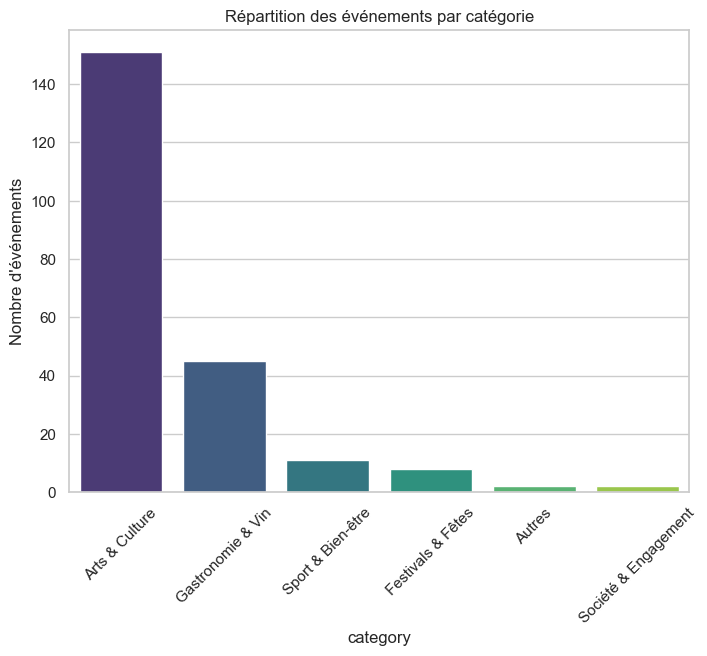

In [199]:
# Répartition des événements par catégorie
import matplotlib.pyplot as plt
import seaborn as sns

# Catégories principales
plt.figure(figsize=(8,6))
cat_count = df_clean['category'].value_counts()
sns.barplot(x=cat_count.index, y=cat_count.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Répartition des événements par catégorie")
plt.ylabel("Nombre d'événements")
plt.show()

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/636141315.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subcat_count.index, y=subcat_count.values, palette="magma")


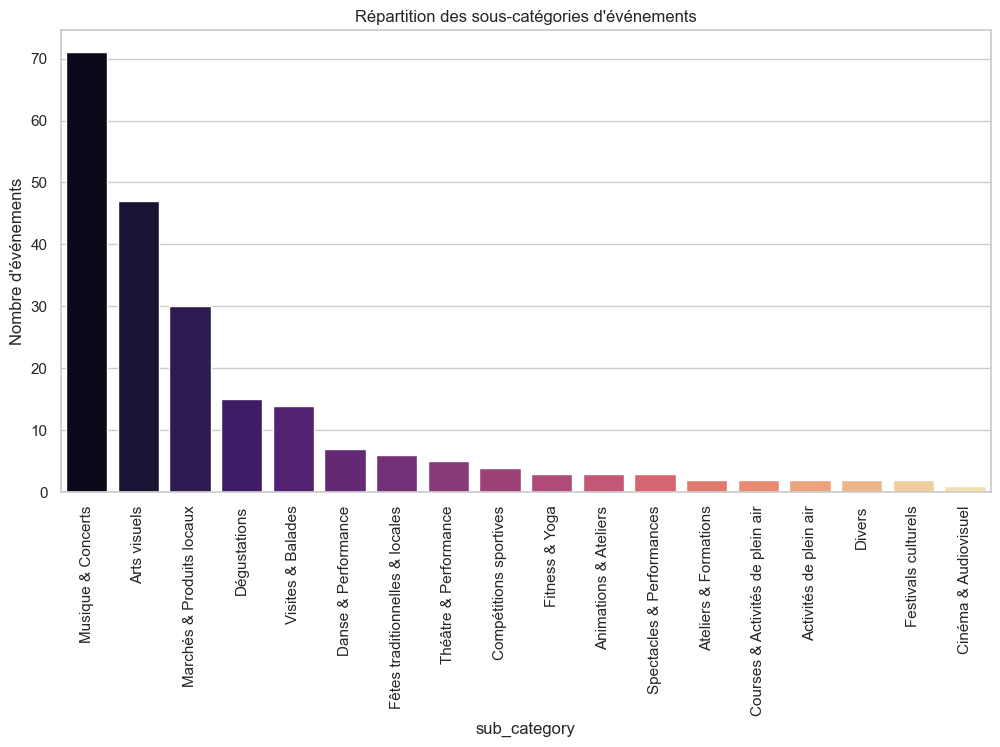

In [200]:
# Répartition des sous-catégories d'événements
plt.figure(figsize=(12,6))
subcat_count = df_clean['sub_category'].value_counts()
sns.barplot(x=subcat_count.index, y=subcat_count.values, palette="magma")
plt.xticks(rotation=90)
plt.title("Répartition des sous-catégories d'événements")
plt.ylabel("Nombre d'événements")
plt.show()

**Insights :**
La catégorie la plus fréquente montre les thématiques dominantes à Bordeaux:Musique et concerts .Elle permet de cibler et matcher entre les preferences clients et les evennements pour avoir une meilleure expérience utilisateur dans le plateforme. 

**Répartition par type de sortie**
Cette analyse montre le type de public visé : en famille, entre amis, professionnel, étudiant… Cela aide à adapter le marketing et les recommandations selon le type de sortie cherchée depuis l'utilisateur.


/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/4089379939.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_count.index, y=type_count.values, palette="coolwarm")


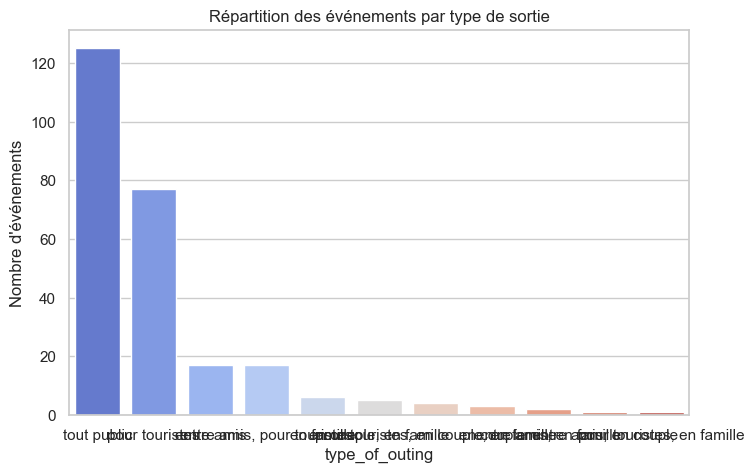

In [201]:
# Répartition par type de sortie
plt.figure(figsize=(8,5))
type_count = df_clean['type_of_outing'].value_counts()
sns.barplot(x=type_count.index, y=type_count.values, palette="coolwarm")
plt.title("Répartition des événements par type de sortie")
plt.ylabel("Nombre d'événements")
plt.show()


**Événements gratuits vs payants**
Cette visualisation permet de voir l’accessibilité financière des événements.

2025-08-31 21:52:38,601 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/756004770.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='is_free', palette='Set2')
2025-08-31 21:52:38,604 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


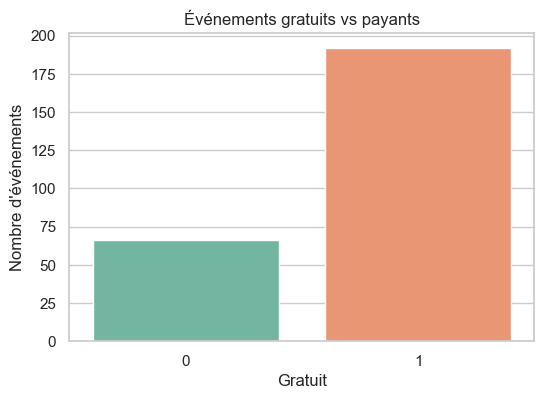

In [202]:
# Événements gratuits vs payants
plt.figure(figsize=(6,4))
sns.countplot(data=df_clean, x='is_free', palette='Set2')
plt.title("Événements gratuits vs payants")
plt.xlabel("Gratuit")
plt.ylabel("Nombre d'événements")
plt.show()


**Distribution des prix des événements**
Le boxplot permet d’identifier les catégories les plus chères et les plus abordables. Cela aide à comprendre le positionnement des événements

**Distribution par type de réservation**
Cette analyse montre les détail de réservation (en ligne, sur place, sans réservation)

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/4011050410.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='reservation_type', order=df_clean['reservation_type'].value_counts().index, palette='Set1')


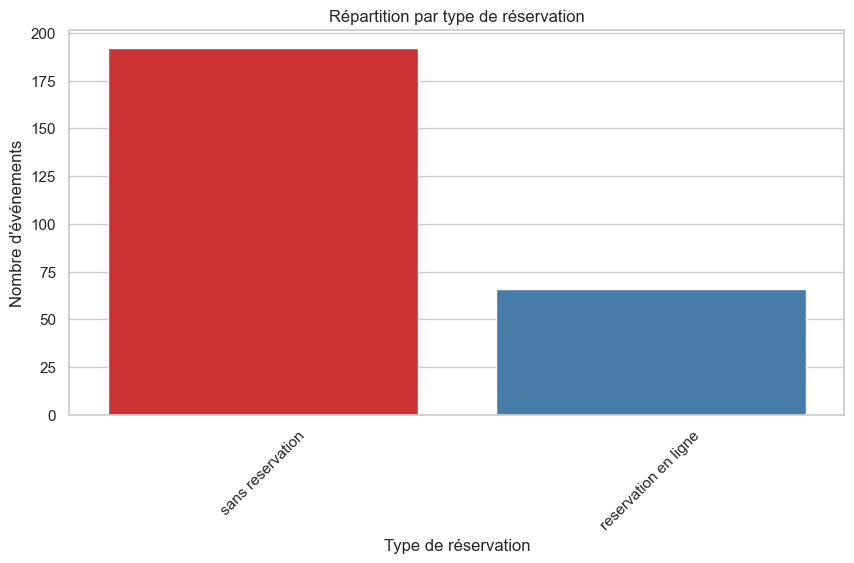

In [203]:
# Distribution des prix des événements
plt.figure(figsize=(10,5))
sns.countplot(data=df_clean, x='reservation_type', order=df_clean['reservation_type'].value_counts().index, palette='Set1')
plt.title("Répartition par type de réservation")
plt.xlabel("Type de réservation")
plt.ylabel("Nombre d'événements")
plt.xticks(rotation=45)
plt.show()


**Distribution temporelle globale**
On peut identifier les jours de forte activité 

In [204]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'reservation_type', 'schedule', 'season',
       'tags', 'ticket_url', 'time', 'title', 'sub_category', 'cible',
       'type_of_outing', 'age_range', 'is_touristic', 'corrected_address',
       'latitude', 'longitude', 'geometry'],
      dtype='object')

**Distribution par saison**
Cette visualisation permet d’identifier si les évennements présents sont saisonnieres ou plutot sur tout l'année.


/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3195938147.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_counts.index, y=season_counts.values, palette="summer")


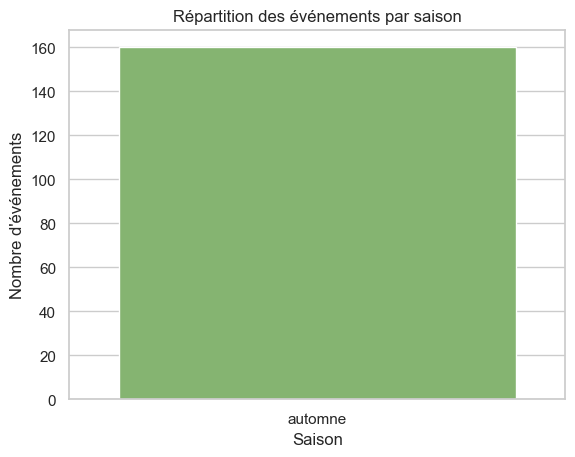

In [205]:
season_counts = df_clean['season'].value_counts()
sns.barplot(x=season_counts.index, y=season_counts.values, palette="summer")
plt.title("Répartition des événements par saison")
plt.xlabel("Saison")
plt.ylabel("Nombre d'événements")
plt.show()


### Analyse Temporelle 

Pour faire l'analyse temporelle ,on commence par creer une dataframe d'analyse temporelle :Cette transformation permet d’analyser les événements jour par jour, plutôt que par événement global. 


In [208]:
import ast

def explode_schedule(df):
    """
    Transforme la colonne 'schedule' en lignes séparées avec date, weekday, start_time, end_time
    """
    from ast import literal_eval
    import json
    from pandas import json_normalize
    
    df_temp = []
    
    for idx, row in df.iterrows():
        schedule_data = row.get('schedule')
    
    # Vérifier si schedule n'est pas vide
        if schedule_data is None or (isinstance(schedule_data, (list, str)) and len(schedule_data) == 0) or (isinstance(schedule_data, str) and not schedule_data.strip()):
            continue

        try:
            # Essayer de parser comme JSON d'abord
            try:
                if isinstance(schedule_data, str):
                    events = json.loads(schedule_data)
                else:
                    events = schedule_data
            except:
                # Si échec, essayer avec literal_eval
                events = literal_eval(str(schedule_data))
            
            # Vérifier si events est une liste
            if not isinstance(events, list):
                continue
                
            for event in events:
                if not isinstance(event, dict):
                    continue
                    
                new_row = {
                    'event_id': row.get('event_id'),
                    'title': row.get('title'),
                    'category': row.get('category'),
                    'subcategory': row.get('subcategory'),
                    'date': event.get('date'),
                    'day_of_week': event.get('weekday'),
                    'start_time': event.get('start_time'),
                    'end_time': event.get('end_time'),
                    'is_weekend': event.get('weekday') in ['Samedi', 'Dimanche'],
                    'is_free': row.get('is_free'),
                    'type_of_outing': row.get('type_of_outing'),
                    'cible': row.get('cible'),
                    'age_range': row.get('age_range')
                }
                df_temp.append(new_row)
                
        except Exception as e:
            print(f"Erreur à la ligne {idx}: {str(e)}")
            continue
    
    if not df_temp:
        return pd.DataFrame()
    
    df_sched = pd.DataFrame(df_temp)
    
    # Nettoyage et conversion des dates
    if 'date' in df_sched.columns:
        df_sched['date'] = pd.to_datetime(df_sched['date'], errors='coerce')
    
    return df_sched

df_schedule = explode_schedule(df_clean)
df_schedule.head()


,event_id,title,category,subcategory,date,day_of_week,start_time,end_time,is_weekend,is_free,type_of_outing,cible,age_range
0,4f29c1ab26128fcfdb70a0176807d325,exposition pollen,Arts & Culture,None,2025-09-02,Tuesday,11h00,18h00,False,0,tout public,grand public,"adults, seniors"
1,4f29c1ab26128fcfdb70a0176807d325,exposition pollen,Arts & Culture,None,2025-09-03,Wednesday,11h00,18h00,False,0,tout public,grand public,"adults, seniors"
2,4f29c1ab26128fcfdb70a0176807d325,exposition pollen,Arts & Culture,None,2025-09-04,Thursday,11h00,18h00,False,0,tout public,grand public,"adults, seniors"
3,4f29c1ab26128fcfdb70a0176807d325,exposition pollen,Arts & Culture,None,2025-09-05,Friday,11h00,18h00,False,0,tout public,grand public,"adults, seniors"
4,4f29c1ab26128fcfdb70a0176807d325,exposition pollen,Arts & Culture,None,2025-09-06,Saturday,11h00,18h00,False,0,tout public,grand public,"adults, seniors"


**Distribution par jour de la semaine**
Cette analyse permet de détecter les jours les plus actifs.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/766055763.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=df_schedule, order=['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'], palette="Set2")


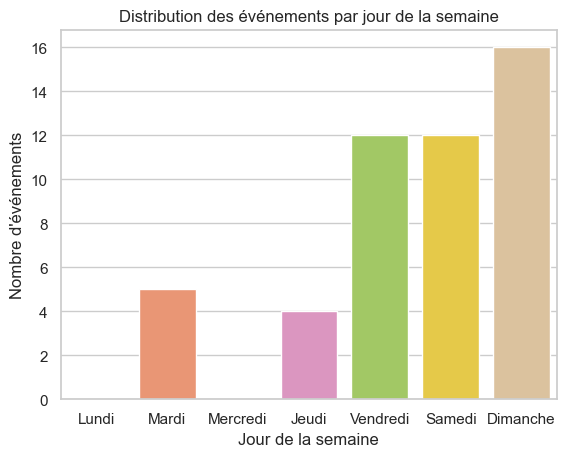

In [209]:
#Distribution par jour de la semaine
sns.countplot(x='day_of_week', data=df_schedule, order=['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'], palette="Set2")
plt.title("Distribution des événements par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre d'événements")
plt.show()


**Distribution week-end vs semaine**
Permet de mesurer la proportion des événements organisés le week-end.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3446503980.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_weekend', data=df_schedule, palette="Set1")


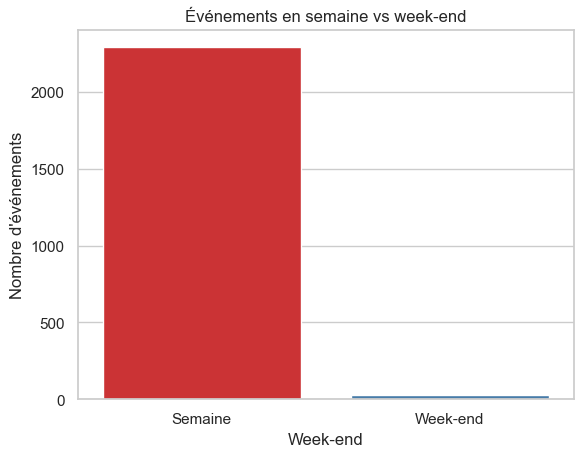

In [210]:
sns.countplot(x='is_weekend', data=df_schedule, palette="Set1")
plt.title("Événements en semaine vs week-end")
plt.xlabel("Week-end")
plt.ylabel("Nombre d'événements")
plt.xticks([0,1], ['Semaine','Week-end'])
plt.show()


**Distribution par créneau horaire**
Cette analyse montre quand les événements se déroulent.Il permet de faire cibler les clientèles selon leurs heurs de recherche

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/1212941728.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='time_slot', data=df_schedule, palette="Paired")


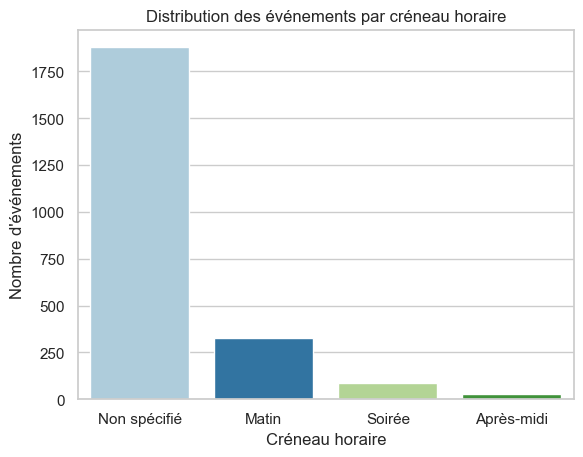

In [211]:
# fonction pour catégoriser le temps
def categorize_time(t):
    try:
        hour = int(t.split(':')[0])
        if 6 <= hour < 12:
            return 'Matin'
        elif 12 <= hour < 18:
            return 'Après-midi'
        elif 18 <= hour <= 23:
            return 'Soirée'
        else:
            return 'Nuit'
    except:
        return 'Non spécifié'

df_schedule['time_slot'] = df_schedule['start_time'].apply(categorize_time)

sns.countplot(x='time_slot', data=df_schedule, palette="Paired")
plt.title("Distribution des événements par créneau horaire")
plt.xlabel("Créneau horaire")
plt.ylabel("Nombre d'événements")
plt.show()


**Temporalité par type de sortie**
On peut visualiser quels types de sortie se produisent à quels moments (ex: sorties en famille surtout l’après-midi, événements professionnels en matinée). Aide à la segmentation de l’audience.


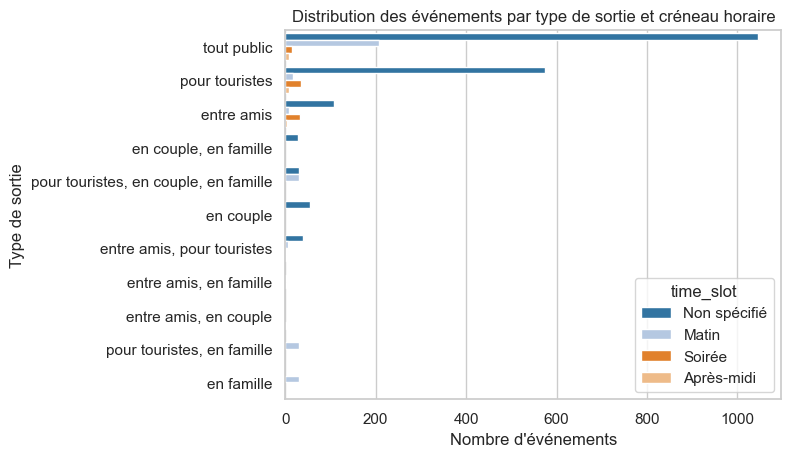

In [212]:
sns.countplot(y='type_of_outing', hue='time_slot', data=df_schedule, palette="tab20")
plt.title("Distribution des événements par type de sortie et créneau horaire")
plt.xlabel("Nombre d'événements")
plt.ylabel("Type de sortie")
plt.show()


**Événements récurrents vs ponctuels**
Permet de détecter les événements récurrents (quotidiens) cela permet de faire ciblé l'importanace et les faisabilités des événements


2025-08-31 21:52:39,188 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3859631963.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_daily', data=df_clean, palette="muted")
2025-08-31 21:52:39,192 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


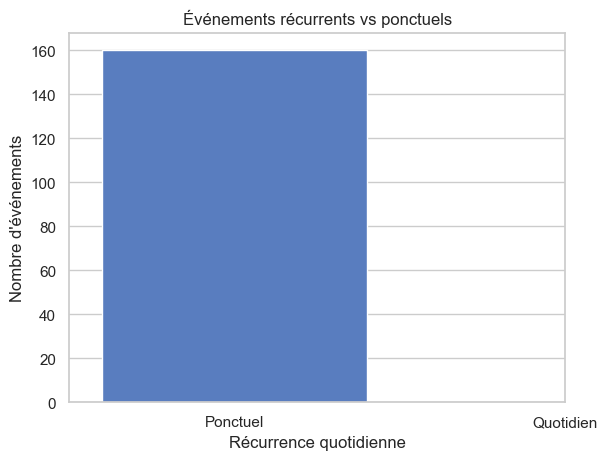

In [213]:
sns.countplot(x='is_daily', data=df_clean, palette="muted")
plt.title("Événements récurrents vs ponctuels")
plt.xlabel("Récurrence quotidienne")
plt.ylabel("Nombre d'événements")
plt.xticks([0,1], ['Ponctuel', 'Quotidien'])
plt.show()


**Temporalité des événements selon les catégories**
On peut identifier quels types d'événements sont concentrés certains jours. 


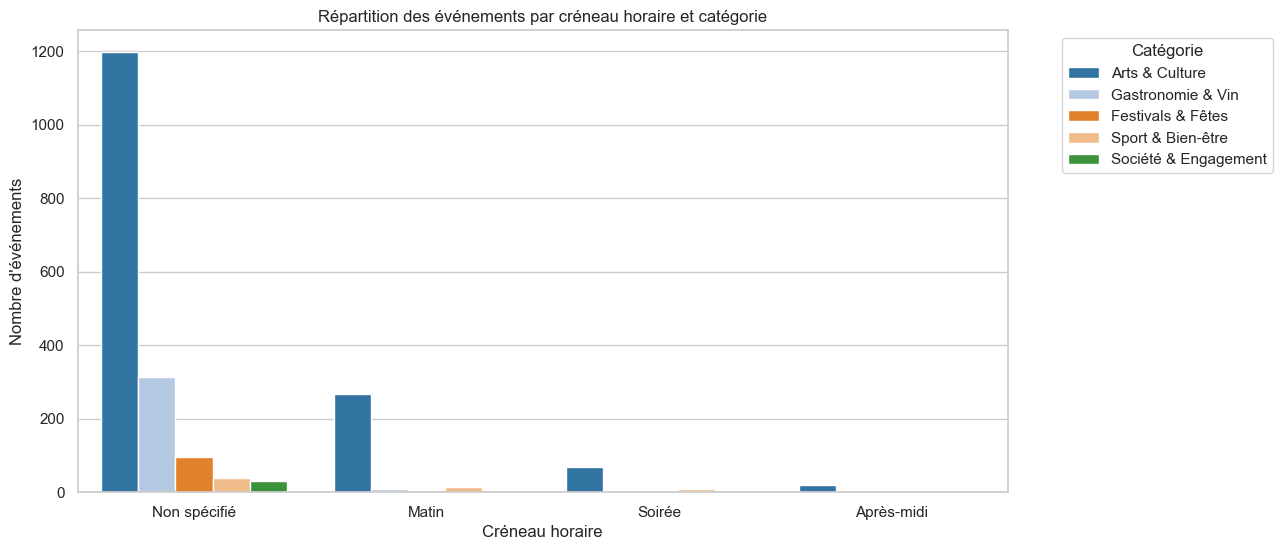

In [214]:
# Distribution par créneau horaire pour chaque catégorie
plt.figure(figsize=(12,6))
sns.countplot(x='time_slot', hue='category', data=df_schedule, palette="tab20")
plt.title("Répartition des événements par créneau horaire et catégorie")
plt.xlabel("Créneau horaire")
plt.ylabel("Nombre d'événements")
plt.legend(title="Catégorie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Analyse géographique

cet analyse nous permet de comprendre la répartition spatiale des événements à Bordeaux, détecter les lieux les plus actifs, identifier des zones chaudes

**Répartition des événements sur la carte de Bordeaux**
Cette visualisation permet d’identifier rapidement la densité des événements.  
On peut voir quelles zones sont très actives et celles moins couvertes.

In [215]:
import folium
from folium.plugins import MarkerCluster

# Centrer la carte sur Bordeaux
bordeaux_lat, bordeaux_lon = 44.8378, -0.5792
m = folium.Map(location=[bordeaux_lat, bordeaux_lon], zoom_start=13)

# Cluster pour regrouper les markers proches
marker_cluster = MarkerCluster().add_to(m)

# Filtrer uniquement les lignes avec latitude et longitude valides
df_valid = df_clean.dropna(subset=['latitude', 'longitude'])

# Ajouter les événements
for idx, row in df_valid.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    title = row.get('title', 'Événement')
    # Assurer que ce sont des floats
    try:
        lat = float(lat)
        lon = float(lon)
        folium.Marker(
            location=[lat, lon],
            popup=title,
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)
    except ValueError:
        continue

# Afficher la carte
m


**Lieux les plus actifs**
Certaines adresses ou lieux concentrent beaucoup d'événements.Cela nous permet de plus cibler et recommander les événements selon la localisation du clients et les evennements qu'il peut les rejoindre selon sa localisation.

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3184698289.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")


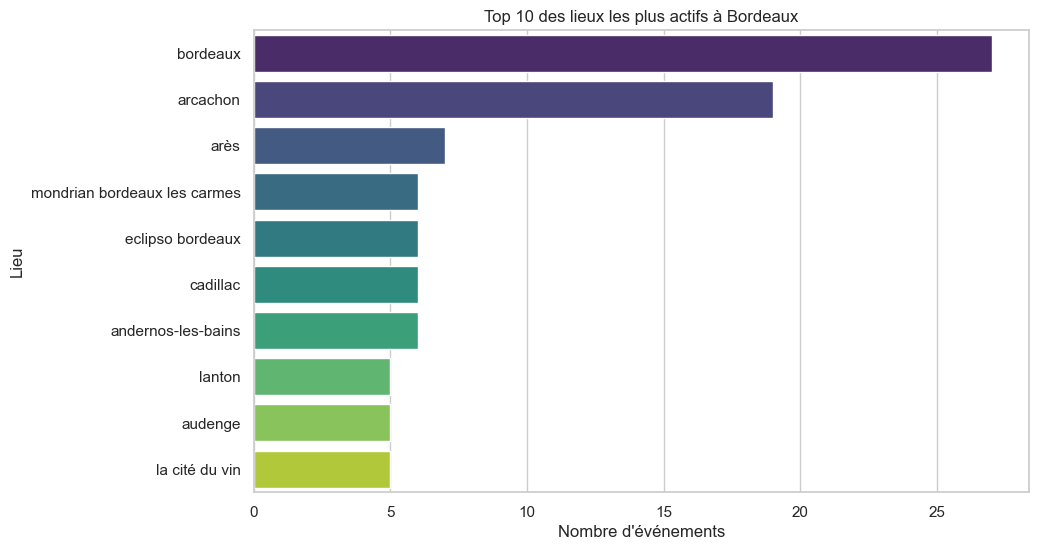

In [216]:
top_locations = df_clean['location'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette="viridis")
plt.title("Top 10 des lieux les plus actifs à Bordeaux")
plt.xlabel("Nombre d'événements")
plt.ylabel("Lieu")
plt.show()


**Distance aux points d’intérêt**
Mesurer la proximité des événements avec les universités, hôtels, lieux touristiques permet d’évaluer l’attractivité et le ciblage du public.


In [217]:
from geopy.distance import geodesic

# Définir les Points d’Intérêt (POIs) dans Bordeaux


POINTS_OF_INTEREST = {
    'universite_bordeaux': 'Université de Bordeaux, 33000 Bordeaux',
    'gare_saint_jean': 'Gare Saint-Jean, Bordeaux',
    'place_de_la_bourse': 'Place de la Bourse, Bordeaux',
    'pey_berland': 'Place Pey Berland, Bordeaux',
    'cite_du_vin': 'La Cité du Vin, Bordeaux',
    'stade_matmut': 'Stade Matmut Atlantique, Bordeaux',
    'aeroport': 'Aéroport de Bordeaux-Mérignac',
    'hotel_de_ville': 'Hôtel de Ville de Bordeaux',
    'jardin_public': 'Jardin Public, Bordeaux',
    'capc': "CAPC Musée d'art contemporain, Bordeaux"
}

In [218]:
# Géocoder les POIs

def geocode_pois(pois_dict):
    coords = {}
    for name, address in pois_dict.items():
        try:
            loc = geolocator.geocode(address + ", France", timeout=10)
            if loc:
                coords[name] = (loc.latitude, loc.longitude)
            else:
                coords[name] = (None, None)
        except:
            coords[name] = (None, None)
        time.sleep(1)  # respecter quotas Nominatim
    return coords

POIS_COORDS = geocode_pois(POINTS_OF_INTEREST)

In [219]:
from geopy.distance import geodesic
import pandas as pd

# Exemple de POIs
POIS_COORDS = {
    "Place de la Bourse": (44.8412, -0.5700),
    "Miroir d'eau": (44.8410, -0.5690),
    "Grand Théâtre": (44.8379, -0.5754)
}

def distance_to_pois(event_coords, pois):
    """
    Retourne un dict des distances de l'événement à chaque POI.
    Si event_coords contient None ou NaN, renvoie None pour chaque POI.
    """
    # Vérifier que event_coords est un tuple/list de 2 éléments valides
    if (not isinstance(event_coords, (tuple, list)) 
        or len(event_coords) != 2 
        or any([pd.isna(c) for c in event_coords])):  # <- correction ici
        return {poi: None for poi in pois.keys()}

    distances = {}
    for poi_name, poi_coords in pois.items():
        if poi_coords and not any([pd.isna(c) for c in poi_coords]):
            distances[poi_name] = geodesic(event_coords, poi_coords).kilometers
        else:
            distances[poi_name] = None
    return distances


# Calcul sécurisé
df_clean["poi_distances"] = df_clean.apply(
    lambda row: distance_to_pois((row["latitude"], row["longitude"]), POIS_COORDS),
    axis=1
)

# Trouver le POI le plus proche
def closest_poi(distances):
    if not distances:
        return None, None
    valid_distances = {k: v for k, v in distances.items() if v is not None}
    if not valid_distances:
        return None, None
    poi, dist = min(valid_distances.items(), key=lambda x: x[1])
    return poi, dist

df_clean[["closest_poi", "closest_dist_km"]] = df_clean["poi_distances"].apply(
    lambda d: pd.Series(closest_poi(d))
)


closest_poi
Grand Théâtre         54
Miroir d'eau          37
Place de la Bourse    27
Name: count, dtype: int64


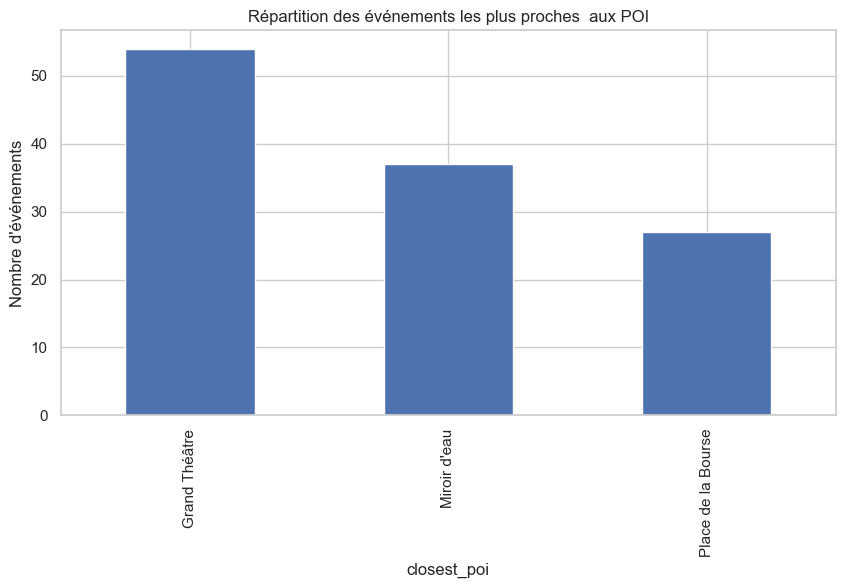

In [220]:

print(df_clean["closest_poi"].value_counts())


import matplotlib.pyplot as plt

df_clean["closest_poi"].value_counts().plot(kind="bar", figsize=(10,5))
plt.title("Répartition des événements les plus proches  aux POI")
plt.ylabel("Nombre d'événements")
plt.show()

In [221]:
m = folium.Map(location=[44.84, -0.58], zoom_start=12)

# Ajouter les POIs
for name, coords in POIS_COORDS.items():
    if coords[0] is not None and coords[1] is not None:
        folium.Marker(
            coords,
            popup=f"{name}",
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(m)

# Ajouter les événements uniquement avec des coordonnées valides
df_valid = df_clean.dropna(subset=["latitude", "longitude"])

for _, row in df_valid.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        popup=f"{row['title']} ({row.get('closest_poi')}, {row.get('closest_dist_km', 0):.2f} km)",
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m

**heatmap des événements touristiques**

In [222]:
from folium.plugins import HeatMap

touristic_events = df_clean[df_clean['is_touristic'] == True]

# Vérifier qu'il y a bien des coordonnées valides
touristic_coords = touristic_events[['latitude', 'longitude']].dropna()

# Convertir en liste de tuples pour HeatMap
heat_data = list(zip(touristic_coords['latitude'], touristic_coords['longitude']))

m_touristic = folium.Map(location=[44.84, -0.58], zoom_start=12)

# Ajouter les POIs
for name, coords in POIS_COORDS.items():
    if coords[0] is not None:
        folium.Marker(
            location=coords,
            popup=f"{name}",
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(m_touristic)

# -------------------------------
# 3️⃣ Ajouter la heatmap pour les événements touristiques
# -------------------------------
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m_touristic)

# -------------------------------
# 4️⃣ Sauvegarder et afficher
# -------------------------------
m_touristic.save("heatmap_touristic_events.html")
m_touristic


### Analyse ciblage / audience

Cet analyse nous permet de comprendre à qui s’adressent les événements, quelles tranches d’âge sont visées, la proportion de gratuité

**Répartition par public cible**
Cette visualisation permet d’identifier les publics majoritairement visés ,ça nous aide pour bien ciblé et facilité et personnalisé la presence des evennement dans le plateforme selon les informations client .


/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/3932309391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, y='cible', order=df_clean['cible'].value_counts().index, palette='viridis')


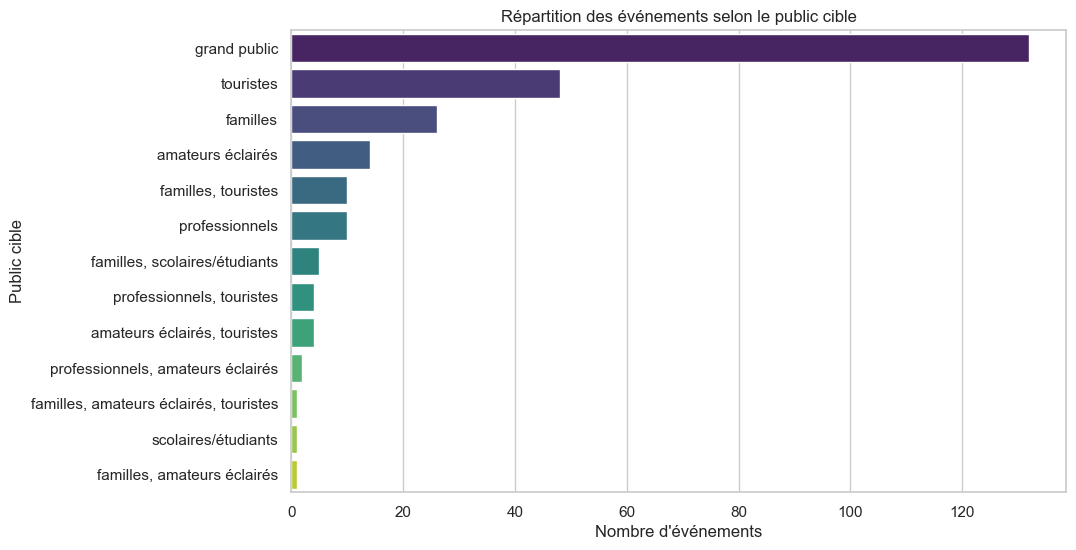

In [223]:


plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, y='cible', order=df_clean['cible'].value_counts().index, palette='viridis')
plt.title("Répartition des événements selon le public cible")
plt.xlabel("Nombre d'événements")
plt.ylabel("Public cible")
plt.show()

**Répartition par tranche d'âge**
Permet de comprendre l’âge moyen du public visé pour différents types d’événements .cela nous aide à matcher les événements futures avec le public visé .

/var/folders/62/qv7mlq7x6r10s2pmbxgzbpzh0000gn/T/ipykernel_90659/840414093.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, y='age_range', order=df_clean['age_range'].value_counts().index, palette='coolwarm')


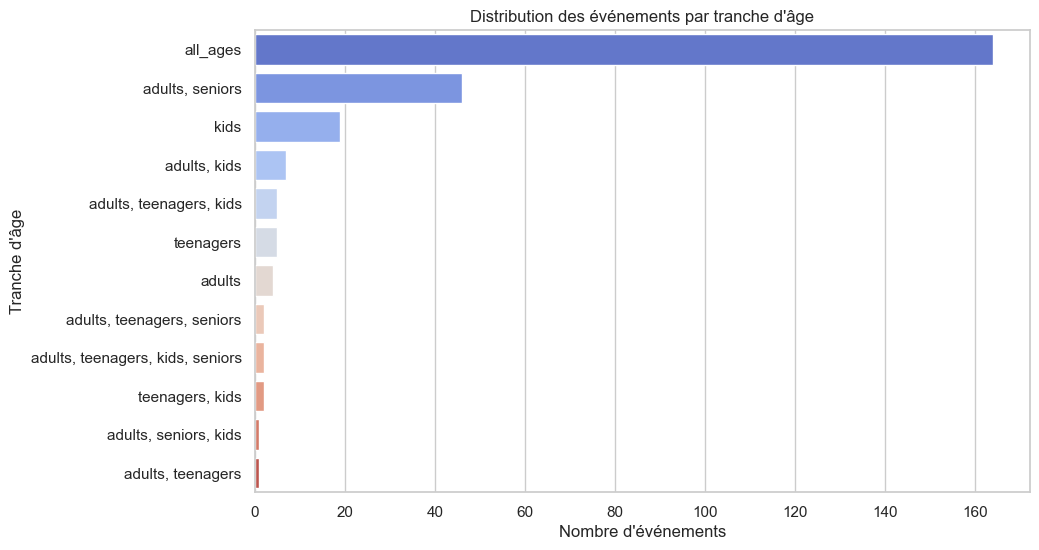

In [224]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, y='age_range', order=df_clean['age_range'].value_counts().index, palette='coolwarm')
plt.title("Distribution des événements par tranche d'âge")
plt.xlabel("Nombre d'événements")
plt.ylabel("Tranche d'âge")
plt.show()

**Gratuité vs Public cible**
Permet d’identifier quelles audiences bénéficient le plus d’événements gratuits.cela nous aide à faire recommandations sur les événements gratuits à organiser pour chaque trance d'age.

2025-08-31 21:52:54,907 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-31 21:52:54,910 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


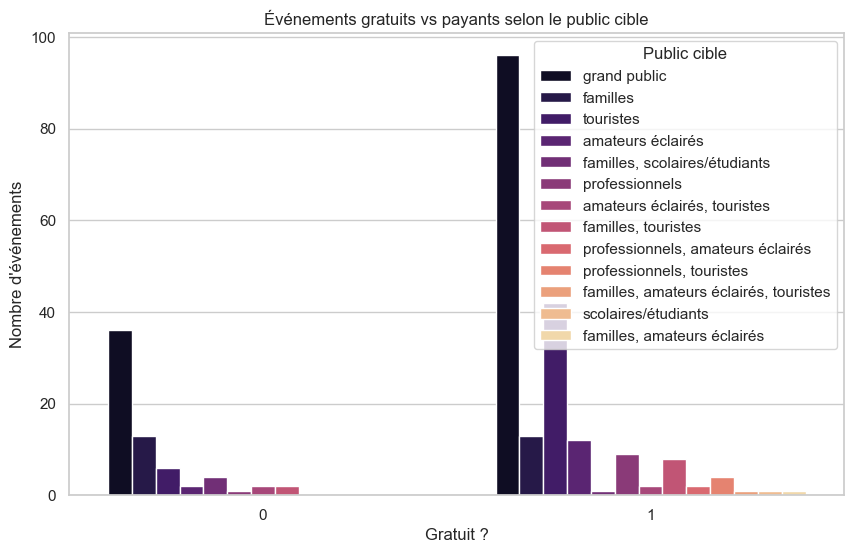

In [225]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, x='is_free', hue='cible', palette='magma')
plt.title("Événements gratuits vs payants selon le public cible")
plt.xlabel("Gratuit ?")
plt.ylabel("Nombre d'événements")
plt.legend(title='Public cible')
plt.show()

**Catégorie vs Tranche d’âge**
Permet d’identifier  la répartition des événements par catégorie et voir quels tranches d’âge sont le plus intéressés.

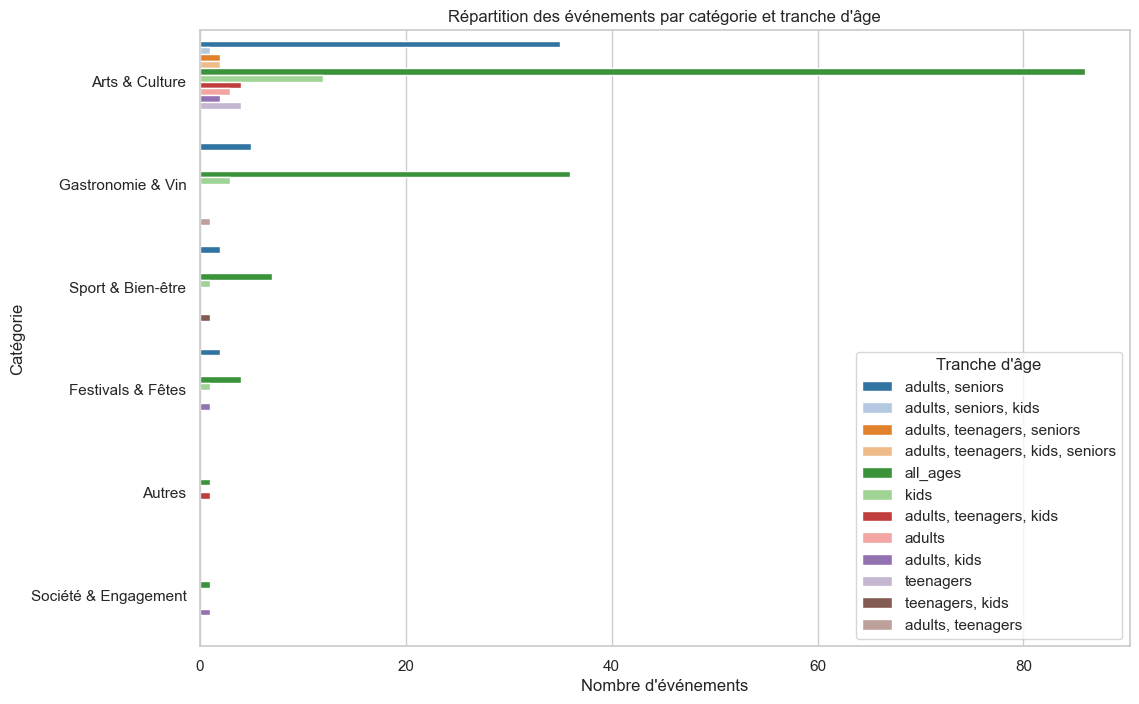

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.countplot(
    data=df_clean,
    y='category',
    hue='age_range',
    order=df_clean['category'].value_counts().index,
    palette='tab20'
)
plt.title("Répartition des événements par catégorie et tranche d'âge")
plt.xlabel("Nombre d'événements")
plt.ylabel("Catégorie")
plt.legend(title="Tranche d'âge")
plt.show()

**Catégorie vs Tranche d’âge**
Permet d’identifier  la répartition des événements par catégorie et voir quels publics sont le plus intéressés.

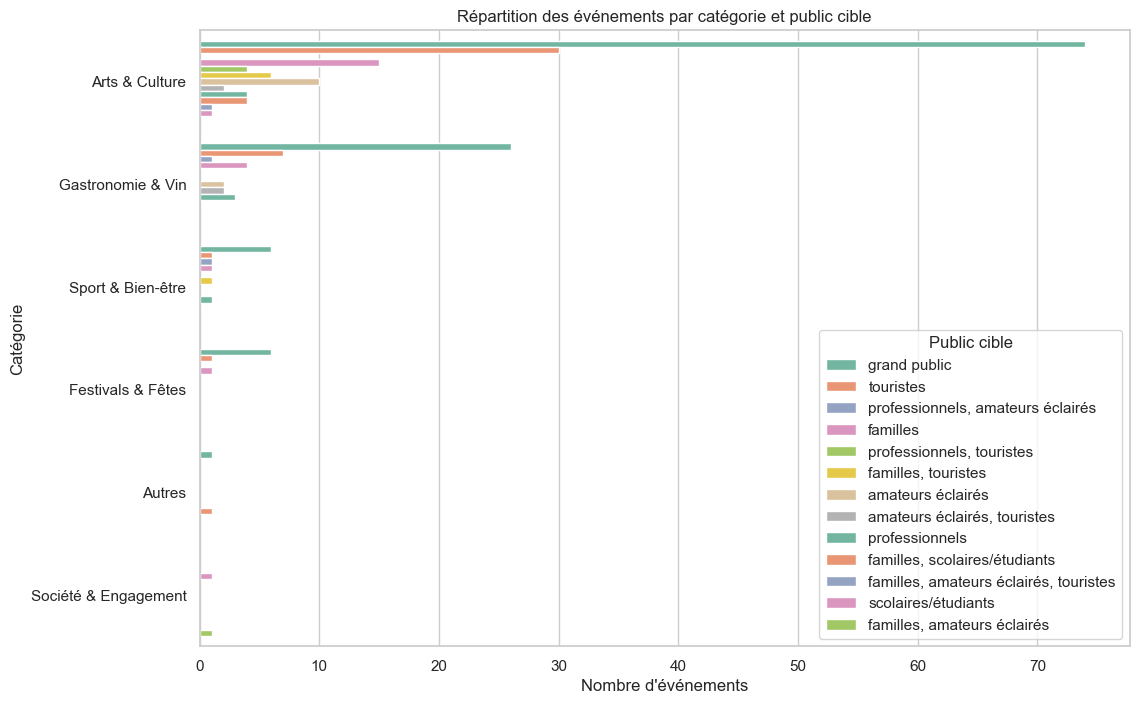

In [227]:
plt.figure(figsize=(12,8))
sns.countplot(
    data=df_clean,
    y='category',
    hue='cible',
    order=df_clean['category'].value_counts().index,
    palette='Set2'
)
plt.title("Répartition des événements par catégorie et public cible")
plt.xlabel("Nombre d'événements")
plt.ylabel("Catégorie")
plt.legend(title="Public cible")
plt.show()

In [228]:
df_clean.columns

Index(['address', 'all_day', 'avg_price', 'category', 'date', 'day_of_week',
       'description', 'duration', 'event_id', 'is_daily', 'is_free',
       'is_weekend', 'location', 'max_price', 'min_price', 'organizer',
       'price', 'price_range', 'reservation_type', 'schedule', 'season',
       'tags', 'ticket_url', 'time', 'title', 'sub_category', 'cible',
       'type_of_outing', 'age_range', 'is_touristic', 'corrected_address',
       'latitude', 'longitude', 'geometry', 'poi_distances', 'closest_poi',
       'closest_dist_km'],
      dtype='object')

## Proposition:système de recommandation basé sur chatbot pour Meeting Potes

L’idée est de proposer une expérience personnalisée à chaque utilisateur de Meeting Potes en lui suggérant les événements les plus pertinents à Bordeaux selon ses préférences :

Catégorie et sous-catégorie (concerts, spectacles, expositions, activités familiales…)

Budget et gratuité des événements

Tranche d’âge et public cible

Localisation (proximité géographique)

Jour et horaire préférés

Le système utilise un score de matching calculé pour chaque événement, combinant différents critères pondérés.

Collecte des préférences utilisateur via un chatbot interactif :

Catégories / sous-catégories

Budget maximum

Tranche d’âge

Jours préférés

Calcul du score de matching :

Catégorie / sous-catégorie : pertinence des événements par rapport aux goûts.

Distance : événements proches de l’utilisateur ou zones d’intérêt (POIs).

Budget : gratuité ou prix ≤ budget utilisateur.

Age : correspondance avec la tranche d’âge cible de l’événement.

Timing : événements aux jours préférés.

Les scores sont pondérés pour refléter l’importance de chaque critère.

Classement des événements par score et affichage des top recommandations :



Infos détaillées : titre, catégorie, prix, adresse, lien billetterie.

In [229]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
# On normalise les prix pour uniformiser les calculs de score et gérer les événements gratuits.
def parse_price(price):
    """
    Convertit une valeur de prix en float.
    Retourne 0 si 'Gratuit' ou non convertible.
    """
    if pd.isna(price):
        return 0.0
    if isinstance(price, str):
        price = price.replace('€','').replace(',','').strip().lower()
        if price in ['gratuit','free','n/a','']:
            return 0.0
    try:
        return float(price)
    except:
        return 0.0



In [230]:
# focntion de scoring:Le scoring est multi-critères pour refléter la pertinence globale
def compute_event_score(event, user_pref, weights):
    score = 0
    
    # Catégorie / sous-catégorie
    cat_match = 1 if str(event.get('category','')).lower() in user_pref.get('categories', []) else 0
    subcat_match = 1 if str(event.get('sub_category','')).lower() in user_pref.get('sub_categories', []) else 0
    score += weights['category'] * (0.7*cat_match + 0.3*subcat_match)
    
    # Distance (proximité géographique)
    if 'location' in user_pref and event.get('latitude') and event.get('longitude'):
        user_loc = user_pref['location']
        event_loc = (event['latitude'], event['longitude'])
        try:
            dist_km = geodesic(user_loc, event_loc).km
            dist_score = max(0, 1 - dist_km / 10)  # Score décroissant avec distance
        except:
            dist_score = 0
        score += weights['distance'] * dist_score
    
    # Budget / gratuité
    avg_price = parse_price(event.get('avg_price', 0))
    max_budget = user_pref.get('budget', np.inf)
    if event.get('is_free', False) and max_budget == 0:
        score += weights['budget']
    else:
        budget_score = max(0, 1 - avg_price / max_budget) if max_budget else 0
        score += weights['budget'] * budget_score
    
    # Tranche d'âge
    if 'age_range' in user_pref and event.get('age_range'):
        try:
            if '-' in event['age_range']:
                e_min, e_max = map(int, event['age_range'].split('-'))
            else:
                e_min = e_max = int(event['age_range'])
            u_min, u_max = user_pref['age_range']
            overlap = max(0, min(e_max,u_max) - max(e_min,u_min))
            age_score = overlap / (e_max - e_min + 1) if (e_max - e_min) > 0 else 1
            score += weights['age'] * age_score
        except:
            pass
    
    # Timing
    if 'day_of_week' in user_pref:
        score += weights['timing'] * (1 if event.get('day_of_week') in user_pref['day_of_week'] else 0)
    
    return score


L’utilisateur peut choisir un point de référence à Bordeaux plutôt que de rentrer manuellement latitude/longitude.

In [231]:
from geopy.geocoders import Nominatim

# Points d'intérêt prédéfinis
POINTS_OF_INTEREST = {
    'universite_bordeaux': 'Université de Bordeaux, 33000 Bordeaux',
    'gare_saint_jean': 'Gare Saint-Jean, Bordeaux',
    'place_de_la_bourse': 'Place de la Bourse, Bordeaux',
    'pey_berland': 'Place Pey Berland, Bordeaux',
    'cite_du_vin': 'La Cité du Vin, Bordeaux',
    'stade_matmut': 'Stade Matmut Atlantique, Bordeaux',
    'aeroport': 'Aéroport de Bordeaux-Mérignac',
    'hotel_de_ville': 'Hôtel de Ville de Bordeaux',
    'jardin_public': 'Jardin Public, Bordeaux',
    'capc': "CAPC Musée d'art contemporain, Bordeaux"
}

geolocator = Nominatim(user_agent="geo_events")

def get_location_from_poi(poi_name):
    """
    Transforme le nom d'un point d'intérêt en coordonnées (latitude, longitude)
    """
    address = POINTS_OF_INTEREST.get(poi_name.lower())
    if not address:
        return None
    loc = geolocator.geocode(address)
    if loc:
        return (loc.latitude, loc.longitude)
    return None

In [232]:
# Chatbot interactif

def event_recommendation_chatbot(df_events, weights):
    print("👋 Bonjour ! Je vais vous recommander des événements à Bordeaux.")
    
    # Préférences utilisateur
    categories = input("💡 Quelles catégories vous intéressent ? (ex: concert, spectacle) ").split(',')
    sub_categories = input("💡 Sous-catégories préférées ? (ex: musique, théâtre) ").split(',')
    budget_input = input("💰 Budget max (ou 'free' pour gratuit) ? ").strip().lower()
    
    if budget_input == 'free':
        max_budget = 0.0
    else:
        try:
            max_budget = float(budget_input)
        except:
            max_budget = np.inf
    
    age_input = input("👶 Tranche d'âge ? (ex: 18-35 ou 25) ")
    try:
        if '-' in age_input:
            age_range = tuple(map(int, age_input.split('-')))
        else:
            val = int(age_input)
            age_range = (val, val)
    except:
        age_range = (0,100)
    
    day_of_week_input = input("📅 Jours préférés ? (ex: Vendredi, Samedi) ").split(',')
    
    # Choix du point d'intérêt comme localisation
    print("\n📍 Choisissez un point de référence pour votre localisation :")
    for key in POINTS_OF_INTEREST:
        print(f"- {key}")
    poi_choice = input("Nom du point d'intérêt (ou 'default' pour Bordeaux centre) : ").strip().lower()
    
    if poi_choice == 'default' or poi_choice not in POINTS_OF_INTEREST:
        location = (44.8378, -0.5792)  # Bordeaux centre par défaut
    else:
        location = get_location_from_poi(poi_choice)
        if not location:
            location = (44.8378, -0.5792)
    
    user_pref = {
        'categories': [c.strip().lower() for c in categories],
        'sub_categories': [c.strip().lower() for c in sub_categories],
        'budget': max_budget,
        'age_range': age_range,
        'day_of_week': [d.strip() for d in day_of_week_input],
        'location': location
    }
    
    # Calcul du score
    df_events['match_score'] = df_events.apply(lambda row: compute_event_score(row, user_pref, weights), axis=1)
    
    # Top 5 recommandations
    top_events = df_events.sort_values(by='match_score', ascending=False).head(5)
    
    print("\n🌟 Voici les événements recommandés pour vous :")
    for i, row in top_events.iterrows():
        print(f"\n🎫 {row['title']} ({row.get('category','N/A')} - {row.get('sub_category','N/A')})")
        print(f"📍 Lieu : {row.get('corrected_address','N/A')}")
        print(f"💰 Prix : {'Gratuit' if row.get('is_free', False) else row.get('avg_price',0)} €")
        print(f"🗓️ Jour : {row.get('day_of_week','N/A')}, {row.get('date','N/A')}")
        print(f"🔗 Billetterie : {row.get('ticket_url','N/A')}")
        print(f"⭐ Score de matching : {row['match_score']:.2f}")


weights = {
    'category': 0.3,
    'distance': 0.25,
    'budget': 0.5,
    'age': 0.45,
    'timing': 0.1
}



In [233]:
df_utilisation = df_clean.copy()
for col in ['avg_price','min_price','max_price']:
    if col in df_utilisation.columns:
        df_utilisation[col] = df_utilisation[col].apply(parse_price)

# Lancer le chatbot
event_recommendation_chatbot(df_utilisation, weights)


👋 Bonjour ! Je vais vous recommander des événements à Bordeaux.

📍 Choisissez un point de référence pour votre localisation :
- universite_bordeaux
- gare_saint_jean
- place_de_la_bourse
- pey_berland
- cite_du_vin
- stade_matmut
- aeroport
- hotel_de_ville
- jardin_public
- capc

🌟 Voici les événements recommandés pour vous :

🎫 visite  nocturne  de  la  cathédrale  saint-andré  de  bordeaux (Arts & Culture - Visites & Balades)
📍 Lieu : pl. pey berland, 33000 bordeaux, bordeaux
💰 Prix : Gratuit €
🗓️ Jour : Saturday, Du Mercredi 30 avril 2025 au Vendredi 14 novembre 2025
🔗 Billetterie : https://cathedra.fr/billetterie/
⭐ Score de matching : 0.75

🎫 visite  nocturne  de  la  cathédrale  saint-andré  de  bordeaux (Arts & Culture - Visites & Balades)
📍 Lieu : cathédrale saint-andré pl. pey berland 33000 bordeaux
💰 Prix : Gratuit €
🗓️ Jour : Monday, 30 avril - 14 novembre
🔗 Billetterie : https://cathedra.fr/billetterie/
⭐ Score de matching : 0.75

🎫 nan (Arts & Culture - Musique & Concerts